DNA HotEncoder Difussion adapted from the Annotated diffusion notebook (https://huggingface.co/blog/annotated-diffusion)


- MILESTONE -> Conditioning is tested and working (check diagonal plot after training to see the results)  (Thanks Zach )  
- Training using 1000 sequences is enought to see the results after ~1000 epochs (kl divergence going down to train and test sequences and increascing to shuffled sequences)  
- Added EMA to smooth the training.  
- Added a function to deal with dataload, motifs generation  and training creation 
- New metrics added KL divergence tested agains (test, train, train shuffled) sequences and per component heatmap plot.
- Added a simple loss visualization using livelossplot.  
- Refactored several functions to plot motif metrix ( others are inside the dataloader new class) 

Contributions   
Lucas Ferreira da Silva  
Luca Pinello
Zach Nussbaum

# Installs and Downloads

In [1]:
!nvidia-smi

Thu Nov  3 13:04:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:25:00.0 Off |                    0 |
| N/A   33C    P0    39W / 250W |  14902MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-PCI...  Off  | 00000000:81:00.0 Off |                    0 |
| N/A   

# Importing

In [98]:
import os

os.getpid()
from scipy.stats import zscore
import torch
import copy
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
from IPython.display import display
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from tqdm import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn.modules.activation import ReLU
from torch.optim import Adam
from tqdm import tqdm_notebook
from torchvision.utils import save_image
import matplotlib
import math
from inspect import isfunction
from functools import partial
import scipy
from scipy.special import rel_entr
from torch import nn, einsum
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange
from torch import nn, einsum
import torch.nn.functional as F
import matplotlib.animation as animation
import matplotlib.image as mpimg
import glob
from PIL import Image

%matplotlib inline

# Utils

In [5]:
class EMA:  # https://github.com/dome272/Diffusion-Models-pytorch/blob/main/modules.py
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(
            current_model.parameters(), ma_model.parameters()
        ):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

In [6]:
nucleotides = ['A', 'C', 'T', 'G']


def one_hot_encode(seq, alphabet, max_seq_len):
    """One-hot encode a sequence."""
    seq_len = len(seq)
    seq_array = np.zeros((max_seq_len, len(alphabet)))
    for i in range(seq_len):
        seq_array[i, alphabet.index(seq[i])] = 1
    return seq_array


def encode(seq, alphabet):
    """Encode a sequence."""
    seq_len = len(seq)
    seq_array = np.zeros(len(alphabet))
    for i in range(seq_len):
        seq_array[alphabet.index(seq[i])] = 1

    return seq_array


def show_seq(dataloader_seq):
    for i_image in dataloader_seq:
        for image in i_image:
            image = image.numpy().reshape(4, 200)
            print(image)
            plt.rcParams["figure.figsize"] = (20, 1)
            pd_seq = pd.DataFrame(image)
            pd_seq.index = nucleotides
            sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0)
            plt.show()


class SequenceDataset(Dataset):
    'Characterizes a dataset for PyTorch'

    def __init__(self, seqs, c, transform=None):
        'Initialization'
        self.seqs = seqs
        self.c = c
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.seqs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        image = self.seqs[index]

        x = self.transform(image)

        y = self.c[index]

        return x, y

## Motif Metric

In [7]:
def sampling_to_metric(
    number_of_samples=20,
    specific_group=False,
    group_number=None,
    cond_weight_to_metric=0,
):
    # Sampling regions using the trained  model
    final_sequences = []
    for n_a in tqdm_notebook(
        range(number_of_samples)
    ):  # generating 20*10 sequences
        # sampled_images = bit_diffusion.sample(batch_size = 4)
        sample_bs = 10
        if specific_group:
            sampled = torch.from_numpy(np.array([group_number] * sample_bs))
            print('specific')
        else:
            sampled = torch.from_numpy(np.random.choice(cell_types, sample_bs))

        #         random_classes = torch.zeros((sample_bs, TOTAL_class_number))
        #         random_classes = random_classes.scatter_(1, sampled.unsqueeze(dim=1), 1).float().cuda()
        random_classes = sampled.float().cuda()
        sampled_images = sample(
            model,
            classes=random_classes,
            image_size=image_size,
            batch_size=sample_bs,
            channels=1,
            cond_weight=cond_weight_to_metric,
        )
        # sampled_images = sampled_images
        for n_b, x in enumerate(sampled_images[-1]):
            # x = x[-1]
            # print(x.shape)
            seq_final = f'>seq_test_{n_a}_{n_b}\n' + ''.join(
                [nucleotides[s] for s in np.argmax(x.reshape(4, 200), axis=0)]
            )
            final_sequences.append(seq_final)

    save_motifs_syn = open('synthetic_motifs.fasta', 'w')

    save_motifs_syn.write('\n'.join(final_sequences))
    save_motifs_syn.close()
    # Scan for motifs
    !gimme scan synthetic_motifs.fasta -p   JASPAR2020_vertebrates -g hg38 > syn_results_motifs.bed
    df_results_syn = pd.read_csv(
        'syn_results_motifs.bed', sep='\t', skiprows=5, header=None
    )
    df_results_syn['motifs'] = df_results_syn[8].apply(
        lambda x: x.split('motif_name "')[1].split('"')[0]
    )
    df_results_syn[0] = df_results_syn[0].apply(
        lambda x: '_'.join(x.split('_')[:-1])
    )
    df_motifs_count_syn = (
        df_results_syn[[0, 'motifs']]
        .drop_duplicates()
        .groupby('motifs')
        .count()
    )
    plt.rcParams["figure.figsize"] = (30, 2)
    df_motifs_count_syn.sort_values(0, ascending=False).head(50)[0].plot.bar()
    plt.show()

    return df_motifs_count_syn


# sampling_to_metric(10)

In [8]:
# np.random.randint(0,2)

In [9]:
# Not using the total number of motifs but the count of the occurence aka: percentage of the sequences with a given motif.
def compare_motif_list(df_motifs_a, df_motifs_b):
    # Using KL divergence to compare motifs lists distribution
    set_all_mot = set(
        df_motifs_a.index.values.tolist() + df_motifs_b.index.values.tolist()
    )
    create_new_matrix = []
    for x in set_all_mot:
        list_in = []
        list_in.append(x)  # adding the name
        if x in df_motifs_a.index:
            list_in.append(df_motifs_a.loc[x][0])
        else:
            list_in.append(1)

        if x in df_motifs_b.index:
            list_in.append(df_motifs_b.loc[x][0])
        else:
            list_in.append(1)

        create_new_matrix.append(list_in)

    df_motifs = pd.DataFrame(
        create_new_matrix, columns=['motif', 'motif_a', 'motif_b']
    )

    df_motifs['Diffusion_seqs'] = (
        df_motifs['motif_a'] / df_motifs['motif_a'].sum()
    )
    df_motifs['Training_seqs'] = (
        df_motifs['motif_b'] / df_motifs['motif_b'].sum()
    )
    plt.rcParams["figure.figsize"] = (3, 3)
    sns.regplot(x='Diffusion_seqs', y='Training_seqs', data=df_motifs)
    plt.xlabel('Diffusion Seqs')
    plt.ylabel('Training Seqs')
    plt.title('Motifs Probs')
    plt.show()

    display(df_motifs)
    kl_pq = rel_entr(
        df_motifs['Diffusion_seqs'].values, df_motifs['Training_seqs'].values
    )
    return np.sum(kl_pq)


# compare_motif_list(synt_df, df_results_seq_guime_count)

# Diffusion

In [20]:
from functools import partial


# ALL THIS FUNCTIONS CHANGED WITH THE CONDITIONAL CODE
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    # print (x.shape, 'x_shape')
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, time=t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise


@torch.no_grad()
def p_sample_guided(
    model, x, classes, t, t_index, context_mask, cond_weight=0.0
):
    # adapted from: https://openreview.net/pdf?id=qw8AKxfYbI
    # print (classes[0])
    batch_size = x.shape[0]
    # double to do guidance with
    t_double = t.repeat(2)
    x_double = x.repeat(2, 1, 1, 1)
    betas_t = extract(betas, t_double, x_double.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t_double, x_double.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t_double, x_double.shape)

    # classifier free sampling interpolates between guided and non guided using `cond_weight`
    classes_masked = classes * context_mask
    classes_masked = classes_masked.type(torch.long)
    # print ('class masked', classes_masked)
    preds = model(x_double, time=t_double, classes=classes_masked)
    eps1 = (1 + cond_weight) * preds[:batch_size]
    eps2 = cond_weight * preds[batch_size:]
    x_t = eps1 - eps2

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t[:batch_size] * (
        x
        - betas_t[:batch_size]
        * x_t
        / sqrt_one_minus_alphas_cumprod_t[:batch_size]
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise


# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, classes, shape, cond_weight):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    if classes is not None:
        n_sample = classes.shape[0]
        context_mask = torch.ones_like(classes).to(device)
        # make 0 index unconditional
        # double the batch
        classes = classes.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 0.0  # makes second half of batch context free
        sampling_fn = partial(
            p_sample_guided,
            classes=classes,
            cond_weight=cond_weight,
            context_mask=context_mask,
        )
    else:
        sampling_fn = partial(p_sample)

    for i in tqdm(
        reversed(range(0, timesteps)),
        desc='sampling loop time step',
        total=timesteps,
    ):
        img = sampling_fn(
            model,
            x=img,
            t=torch.full((b,), i, device=device, dtype=torch.long),
            t_index=i,
        )
        imgs.append(img.cpu().numpy())
    return imgs


@torch.no_grad()
def sample(
    model, image_size, classes=None, batch_size=16, channels=3, cond_weight=0
):
    return p_sample_loop(
        model,
        classes=classes,
        shape=(batch_size, channels, 4, image_size),
        cond_weight=cond_weight,
    )

### schedule

In [21]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = (
        torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    )
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)


def linear_beta_schedule(timesteps, beta_end=0.005):
    beta_start = 0.0001

    return torch.linspace(beta_start, beta_end, timesteps)


def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2


def sigmoid_beta_schedule(timesteps):
    beta_start = 0.001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

### Foward diffusion


In [22]:
# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    # print  (sqrt_alphas_cumprod_t , sqrt_one_minus_alphas_cumprod_t , t)

    return (
        sqrt_alphas_cumprod_t * x_start
        + sqrt_one_minus_alphas_cumprod_t * noise
    )

In [23]:
torch.bernoulli(torch.zeros(10) + (1 - 0.1))

tensor([1., 1., 1., 1., 0., 1., 0., 1., 0., 1.])

### Loss

In [24]:
# THIS function changed to accomodate the conditional


def p_losses(
    denoise_model, x_start, t, classes, noise=None, loss_type="l1", p_uncond=0.1
):
    device = x_start.device
    if noise is None:
        noise = torch.randn_like(x_start)  #  guass noise
    x_noisy = q_sample(
        x_start=x_start, t=t, noise=noise
    )  # this is the auto generated noise given t and Noise
    # print('max_q_sample', x_noisy.max(), 'mean_q_sample',x_noisy.mean() )

    context_mask = torch.bernoulli(
        torch.zeros(classes.shape[0]) + (1 - p_uncond)
    ).to(device)
    # print ('context mask', context_mask)
    # print ('classes', classes)

    # mask for unconditinal guidance
    classes = classes * context_mask
    # nn.Embedding needs type to be long, multiplying with mask changes type
    classes = classes.type(torch.long)
    # print ('final class',classes )
    predicted_noise = denoise_model(
        x_noisy, t, classes
    )  # this is the predicted noise given the model and step t
    # print('max_predicted', x_noisy.max(), 'mean_predicted',x_noisy.mean() )

    # #predicted is ok (clipped)
    # print ('predited inside loss')
    # print (predicted_noise)
    # print ('this is the noise generated by the p_losses')
    # print (noise)
    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        # print (noise.shape, 'noise' )
        # print (predicted_noise.shape, 'pred')
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

# Models

In [25]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(
            torch.arange(half_dim, device=device) * -embeddings
        )
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class ResBlock(nn.Module):

    """
    Iniialize a residual block with two convolutions followed by batchnorm layers
    """

    def __init__(self, in_size: int, hidden_size: int, out_size: int):
        super().__init__()
        self.conv1 = nn.Conv2d(in_size, hidden_size, 3, padding=1)
        self.conv2 = nn.Conv2d(hidden_size, out_size, 3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(hidden_size)
        self.batchnorm2 = nn.BatchNorm2d(out_size)

    def convblock(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.relu(self.batchnorm2(self.conv2(x)))
        return x

    """
    Combine output with the original input
    """

    def forward(self, x):
        return x + self.convblock(x)  # skip connection


class ConvBlock_2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, padding=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 4, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # print ('x', x.shape)
        x = self.conv1(x)
        # print ('conv1', x.shape)
        x = self.conv2(x)
        # print ('conv2', x.shape)
        # x = F.avg_pool2d(x, 2)

        return x


class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.res = nn.Sequential(
            ResBlock(1, 2, 1),
            ResBlock(1, 2, 1),
            ResBlock(1, 2, 1),
            ResBlock(1, 2, 1),
        )

        self.conv = nn.Sequential(
            ConvBlock_2d(in_channels=1, out_channels=2),
            nn.ReLU(),
            nn.BatchNorm2d(2),
            ConvBlock_2d(in_channels=2, out_channels=4),
            nn.ReLU(),
            nn.BatchNorm2d(4),
            ConvBlock_2d(in_channels=4, out_channels=1),
            nn.BatchNorm2d(1)
            # ConvBlock_2d(in_channels=1, out_channels=1),
            # ConvBlock_2d(in_channels=1, out_channels=1),
            # ConvBlock_2d(in_channels=1, out_channels=1),
        )

        self.fc = nn.Sequential(
            nn.Linear(800, 800),
            # nn.GELU(),
            nn.BatchNorm1d(
                800
            ),  # ALWAYS BATCHNORM THIS CHANGES A LOT THE RESULTS
            # nn.Linear(400, 400),
            # nn.BatchNorm1d(400),
            # nn.GELU(),
            # nn.BatchNorm1d(400),
        )

        self.fc2 = nn.Sequential(
            nn.Linear(400, 800),
            # nn.GELU(),
            nn.BatchNorm1d(
                800
            ),  # ALWAYS BATCHNORM THIS CHANGES A LOT THE RESULTS
            # nn.Linear(400, 400),
            # nn.GELU(),
            # nn.BatchNorm1d(400),
        )

        time_dim = 200 * 4
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(100),
            nn.Linear(100, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        self.time_mlp_out = nn.Sequential(
            SinusoidalPositionEmbeddings(100),
            nn.Linear(100, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

    def forward(self, x, y):
        # print (x.shape, 'inside model x ')
        x_a = x.clone()
        # y_a = y.clone()
        x = self.res(x)

        # print ('to_full', x.shape)

        y_emb = self.time_mlp(y)
        # y_emb_out = self.time_mlp_out(y_a)

        x = x.view(-1, 800)

        x_a = x.view(-1, 800)
        x_a = self.fc(x_a)

        x = x + y_emb.view(-1, 800) * x_a

        # x = self.fc2(x)
        # x = x + y_emb_out.view(-1,400) + x_a

        # x = torch.clip(x, min=-1, max=1)
        x = x.view(-1, 1, 4, 200)

        # x = x.view(-1,1,200,4)

        # print (x.shape)
        # The cliping is working already checked
        return x

### UNET and UTILS

In [26]:
# THIS is a new function  to accomodate the conditional


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [27]:
# This session changed a lot to accomodate the conditional generation


def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d


def cycle(dl):
    while True:
        for data in dl:
            yield data


def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num


def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr


def convert_image_to(img_type, image):
    if image.mode != img_type:
        return image.convert(img_type)
    return image


def l2norm(t):
    return F.normalize(t, dim=-1)


# small helper modules


def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding=1),
    )


def Downsample(dim, dim_out=None):
    return nn.Conv2d(dim, default(dim_out, dim), 4, 2, 1)


class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim=1, unbiased=False, keepdim=True)
        mean = torch.mean(x, dim=1, keepdim=True)
        return (x - mean) * (var + eps).rsqrt() * self.g


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)


# positional embeds


class LearnedSinusoidalPosEmb(nn.Module):
    """following @crowsonkb 's lead with learned sinusoidal pos emb"""

    """ https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/models/danbooru_128.py#L8 """

    def __init__(self, dim):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim))

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim=-1)
        fouriered = torch.cat((x, fouriered), dim=-1)
        return fouriered


# building block modules


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = (
            nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()
        )

    def forward(self, x, time_emb=None):
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)

        h = self.block2(h)

        return h + self.res_conv(x)


class ResnetBlockClassConditioned(ResnetBlock):
    def __init__(
        self,
        dim,
        dim_out,
        *,
        num_classes,
        class_embed_dim,
        time_emb_dim=None,
        groups=8,
    ):
        super().__init__(
            dim=dim + class_embed_dim,
            dim_out=dim_out,
            time_emb_dim=time_emb_dim,
            groups=groups,
        )
        # print ('n_classes', num_classes, 'class_embed_dim', class_embed_dim)
        self.class_mlp = EmbedFC(num_classes, class_embed_dim)

    def forward(self, x, time_emb=None, c=None):
        # print ('before class_mlp')
        emb_c = self.class_mlp(c)
        # print ('after class_mlp')
        emb_c = emb_c.view(*emb_c.shape, 1, 1)
        emb_c = emb_c.expand(-1, -1, x.shape[-2], x.shape[-1])
        x = torch.cat([x, emb_c], axis=1)

        return super().forward(x, time_emb)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1), LayerNorm(dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h=self.heads),
            qkv,
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        v = v / (h * w)

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(
            out, 'b h c (x y) -> b (h c) x y', h=self.heads, x=h, y=w
        )
        return self.to_out(out)


class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32, scale=10):
        super().__init__()
        self.scale = scale
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h=self.heads),
            qkv,
        )

        q, k = map(l2norm, (q, k))

        sim = einsum('b h d i, b h d j -> b h i j', q, k) * self.scale
        attn = sim.softmax(dim=-1)
        out = einsum('b h i j, b h d j -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x=h, y=w)
        return self.to_out(out)


# model

# bit diffusion class


def log(t, eps=1e-20):
    return torch.log(t.clamp(min=eps))


def right_pad_dims_to(x, t):
    padding_dims = x.ndim - t.ndim
    if padding_dims <= 0:
        return t
    return t.view(*t.shape, *((1,) * padding_dims))


def beta_linear_log_snr(t):
    return -torch.log(expm1(1e-4 + 10 * (t**2)))


def alpha_cosine_log_snr(t, s: float = 0.008):
    return -log(
        (torch.cos((t + s) / (1 + s) * math.pi * 0.5) ** -2) - 1, eps=1e-5
    )  # not sure if this accounts for beta being clipped to 0.999 in discrete version


def log_snr_to_alpha_sigma(log_snr):
    return torch.sqrt(torch.sigmoid(log_snr)), torch.sqrt(
        torch.sigmoid(-log_snr)
    )


class Unet_lucas(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        dim_mults=(1, 2, 4),
        channels=1,
        resnet_block_groups=8,
        learned_sinusoidal_dim=18,
        num_classes=10,
        class_embed_dim=3,
    ):
        super().__init__()

        # determine dimensions

        channels = 1
        self.channels = channels
        # if you want to do self conditioning uncomment this
        # input_channels = channels * 2
        input_channels = channels

        init_dim = default(init_dim, dim)
        # print (init_dim, 'init_dim')
        # self.init_conv = nn.Conv2d(input_channels, init_dim, 7, padding = 3) # original
        self.init_conv = nn.Conv2d(input_channels, init_dim, (7, 7), padding=3)

        # print (self.init_conv)
        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        # print (dims)

        in_out = list(zip(dims[:-1], dims[1:]))
        # print (in_out)
        #         block_klass = partial(ResnetBlockClassConditioned, groups=resnet_block_groups,
        #                              num_classes=num_classes, class_embed_dim=class_embed_dim)

        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings

        time_dim = dim * 4

        sinu_pos_emb = LearnedSinusoidalPosEmb(learned_sinusoidal_dim)
        fourier_dim = learned_sinusoidal_dim + 1

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

        # layers

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Downsample(dim_in, dim_out)
                        if not is_last
                        else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(
                            dim_out + dim_in, dim_out, time_emb_dim=time_dim
                        ),
                        block_klass(
                            dim_out + dim_in, dim_out, time_emb_dim=time_dim
                        ),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Upsample(dim_out, dim_in)
                        if not is_last
                        else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim)
        # self.final_res_block = block_klass(1, dim, time_emb_dim = time_dim)

        # self.final_conv = nn.Conv2d(dim, channels, 1)
        self.final_conv = nn.Conv2d(dim, 1, 1)
        # print('self.final_conv' , self.final_conv)

        print('final', dim, channels, self.final_conv)

    def forward(self, x, time, classes, x_self_cond=None):
        # print (x.shape ,'in_shape')
        # x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
        # x = torch.cat((x_self_cond, x), dim = 1)
        # print ('UNET')
        # print ('classes inside unet',classes, 'time inside unet', time)
        x = self.init_conv(x)
        # print ('init_conv', x.shape)
        r = x.clone()

        t_start = self.time_mlp(time)
        t_mid = t_start.clone()
        t_end = t_start.clone()

        if classes is not None:
            t_start += self.label_emb(classes)
            t_mid += self.label_emb(classes)
            t_end += self.label_emb(classes)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t_start)  # , classes)
            h.append(x)

            x = block2(x, t_start)  # , classes)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t_mid)  # , classes)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t_mid)  # , classes)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t_mid)  # , classes)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t_mid)  # , classes)
            x = attn(x)

            x = upsample(x)

        # print('x torch_after_upsamples',x.shape)

        x = torch.cat((x, r), dim=1)
        # print('x tochcat', x.shape)

        x = self.final_res_block(x, t_end)  # , classes)
        # print(self.final_res_block)
        # print('x from res_block before final_conv',x.shape)
        # print (self.final_conv(x).shape)
        x = self.final_conv(x)
        # print ('FINAL X', x.shape)
        return x

# Loading data and generating fasta files and motifs

Subseting...


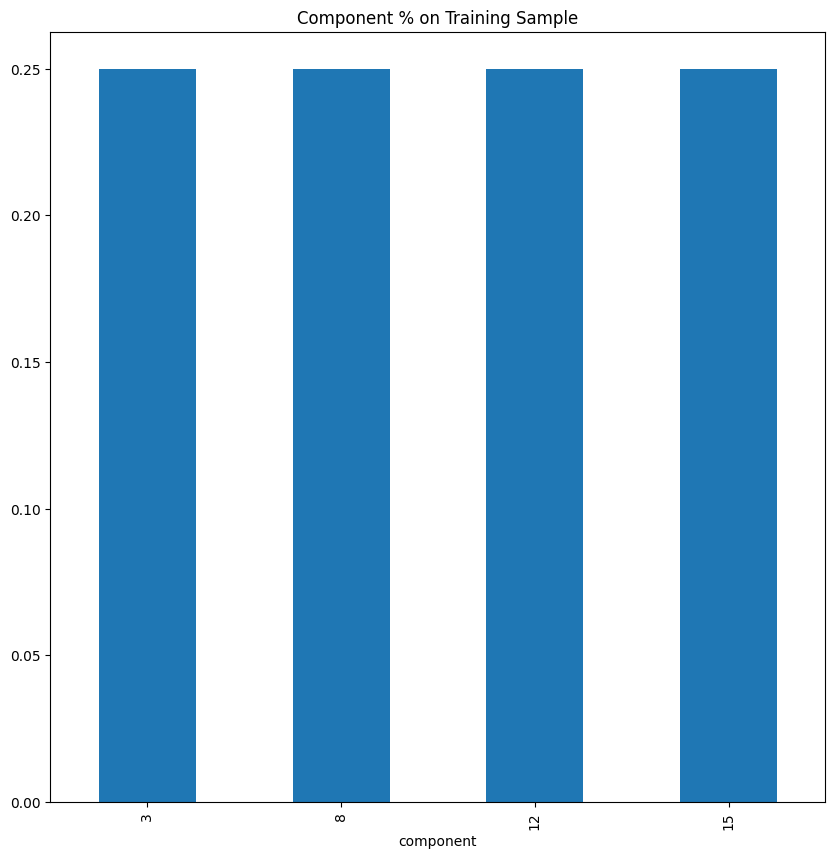

Generating Fasta and Motis: train
------------------------------
Generating Motifs (all seqs)
Computing Motifs....
scanning: 100%|█████████████████████| 1000/1000 [00:11<00:00, 83.99 sequences/s]


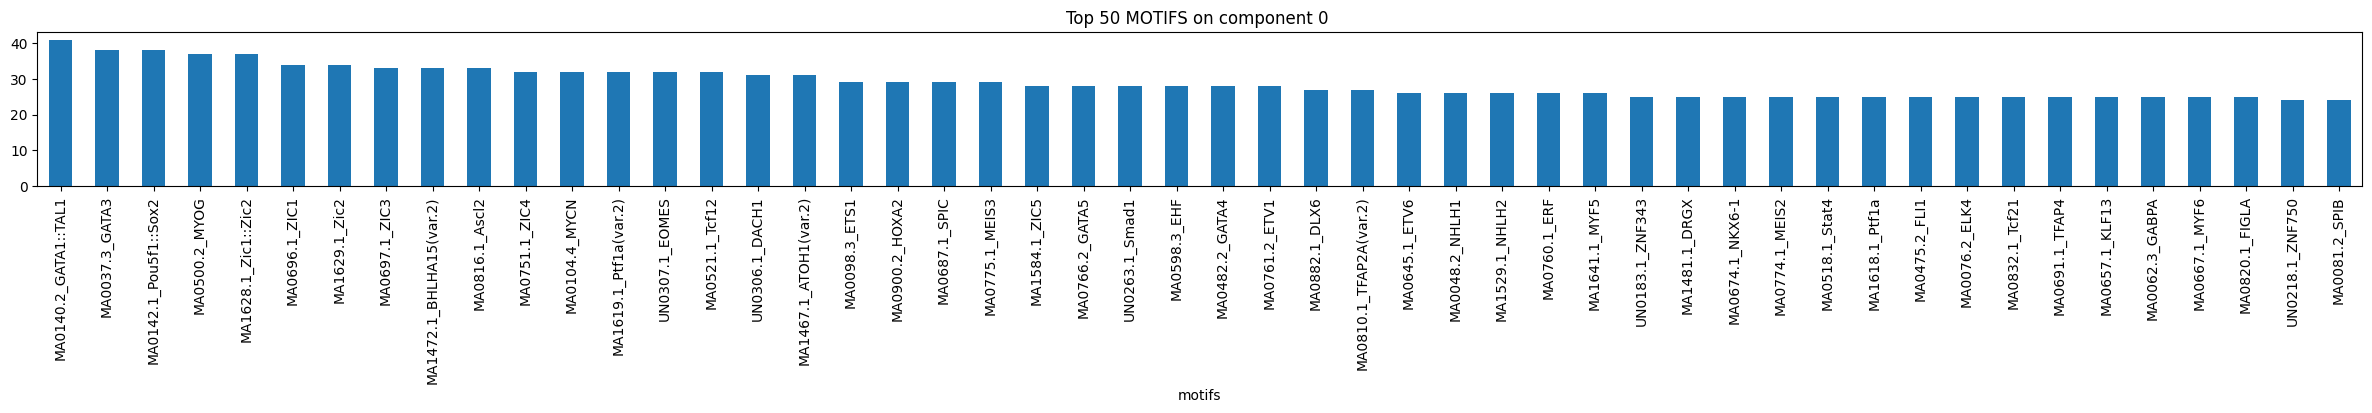

Generating Motifs per component
3
Computing Motifs....
scanning: 100%|███████████████████████| 255/255 [00:06<00:00, 41.29 sequences/s]


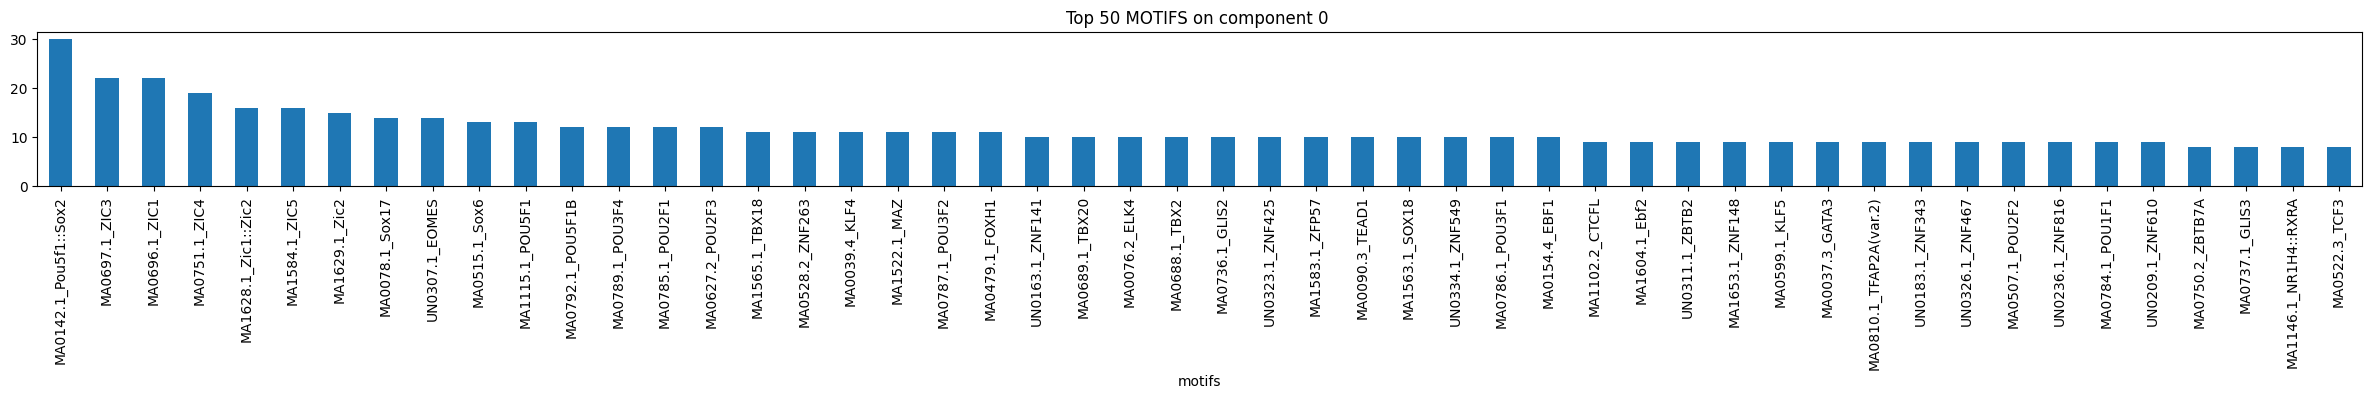

8
Computing Motifs....
scanning: 100%|███████████████████████| 249/249 [00:06<00:00, 40.35 sequences/s]


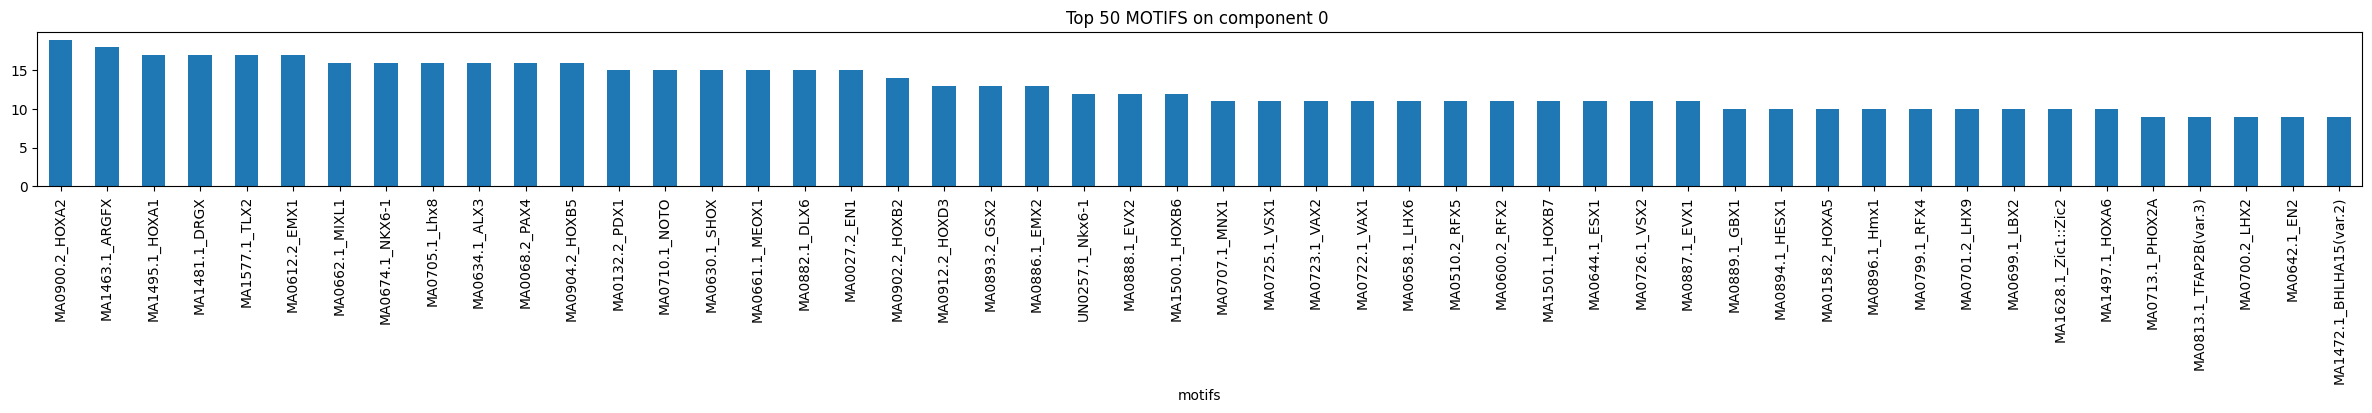

12
Computing Motifs....
scanning: 100%|███████████████████████| 245/245 [00:06<00:00, 40.23 sequences/s]


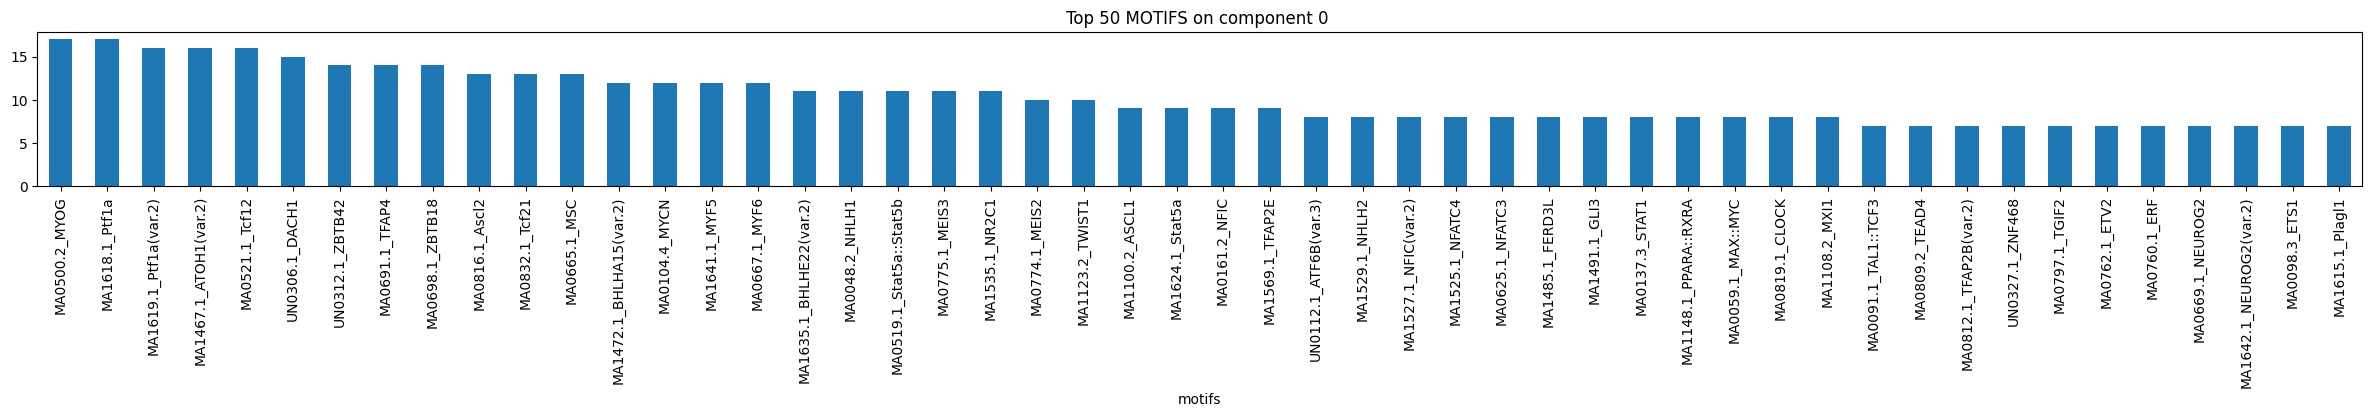

15
Computing Motifs....
scanning: 100%|███████████████████████| 251/251 [00:06<00:00, 38.93 sequences/s]


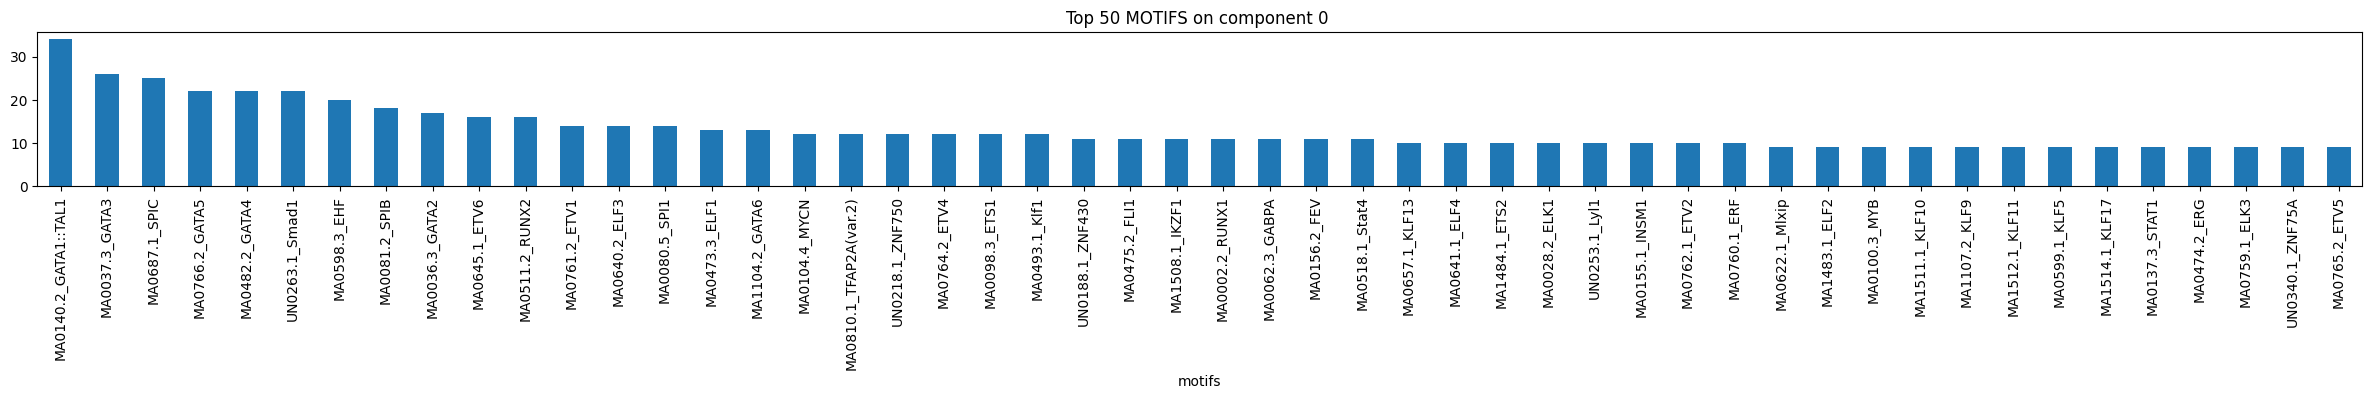

Generating Fasta and Motis: test
------------------------------
Generating Motifs (all seqs)
Computing Motifs....
scanning: 100%|█████████████████████| 1000/1000 [00:12<00:00, 80.53 sequences/s]


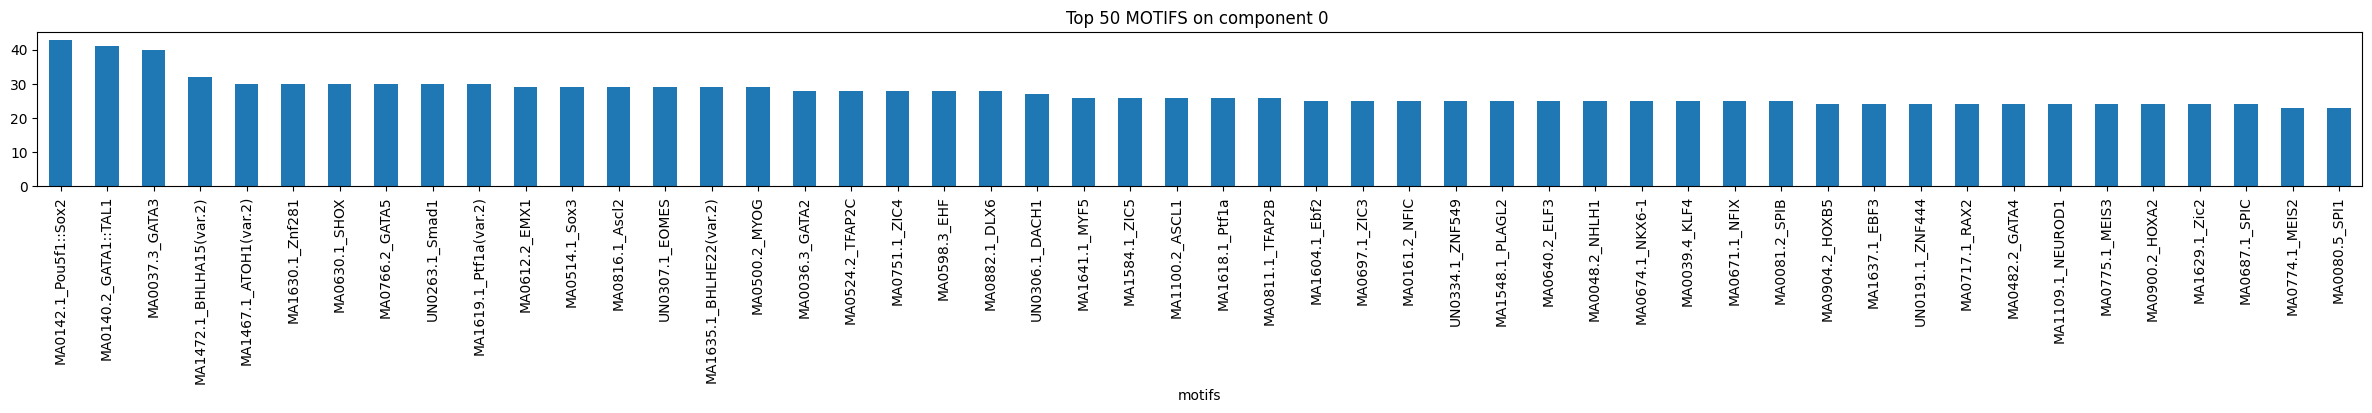

Generating Motifs per component
3
Computing Motifs....
scanning: 100%|███████████████████████| 258/258 [00:06<00:00, 38.58 sequences/s]


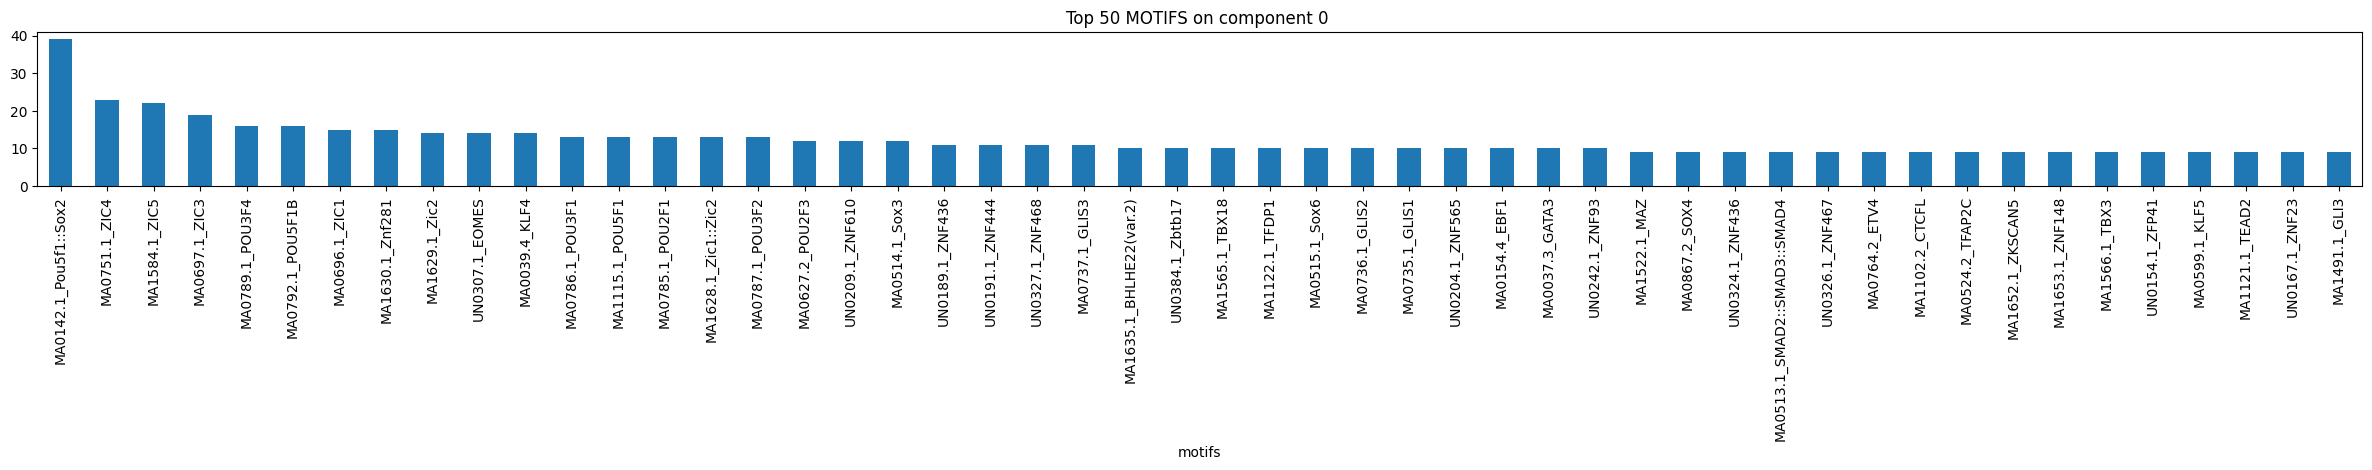

8
Computing Motifs....
scanning: 100%|███████████████████████| 248/248 [00:06<00:00, 40.65 sequences/s]


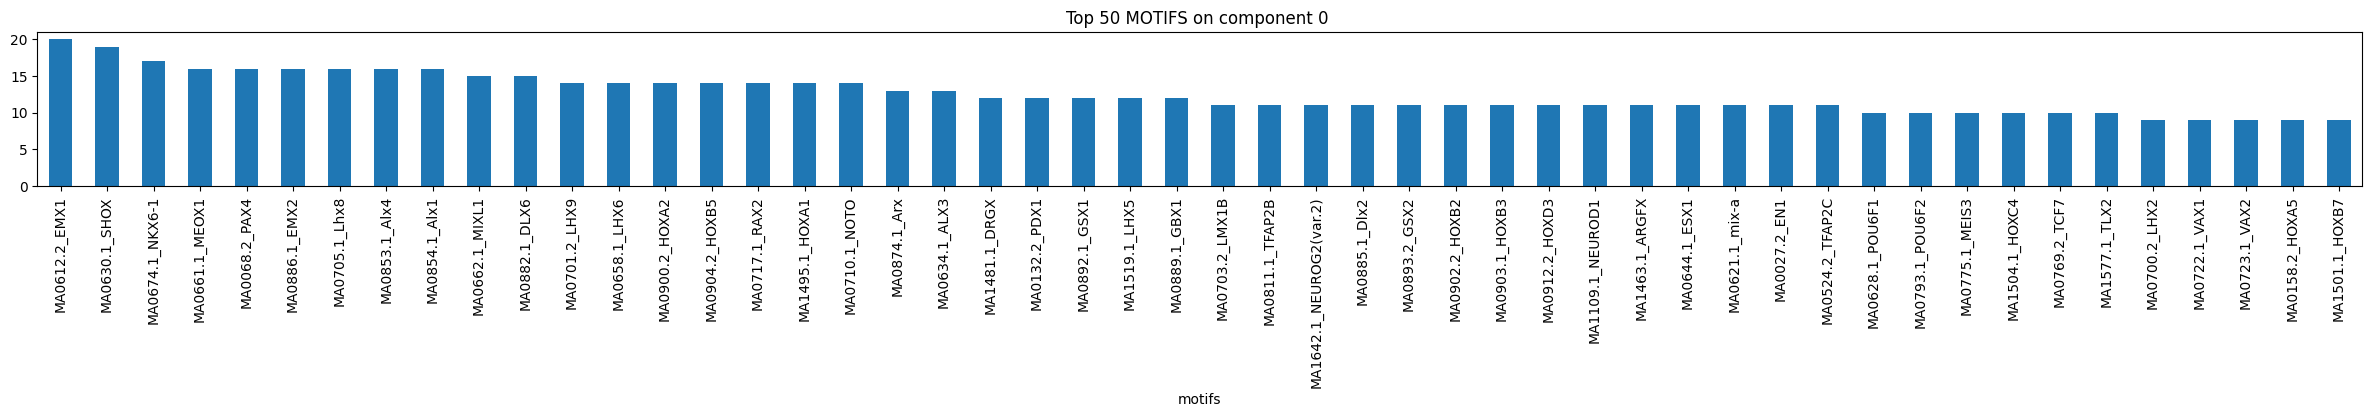

12
Computing Motifs....
scanning: 100%|███████████████████████| 256/256 [00:06<00:00, 41.31 sequences/s]


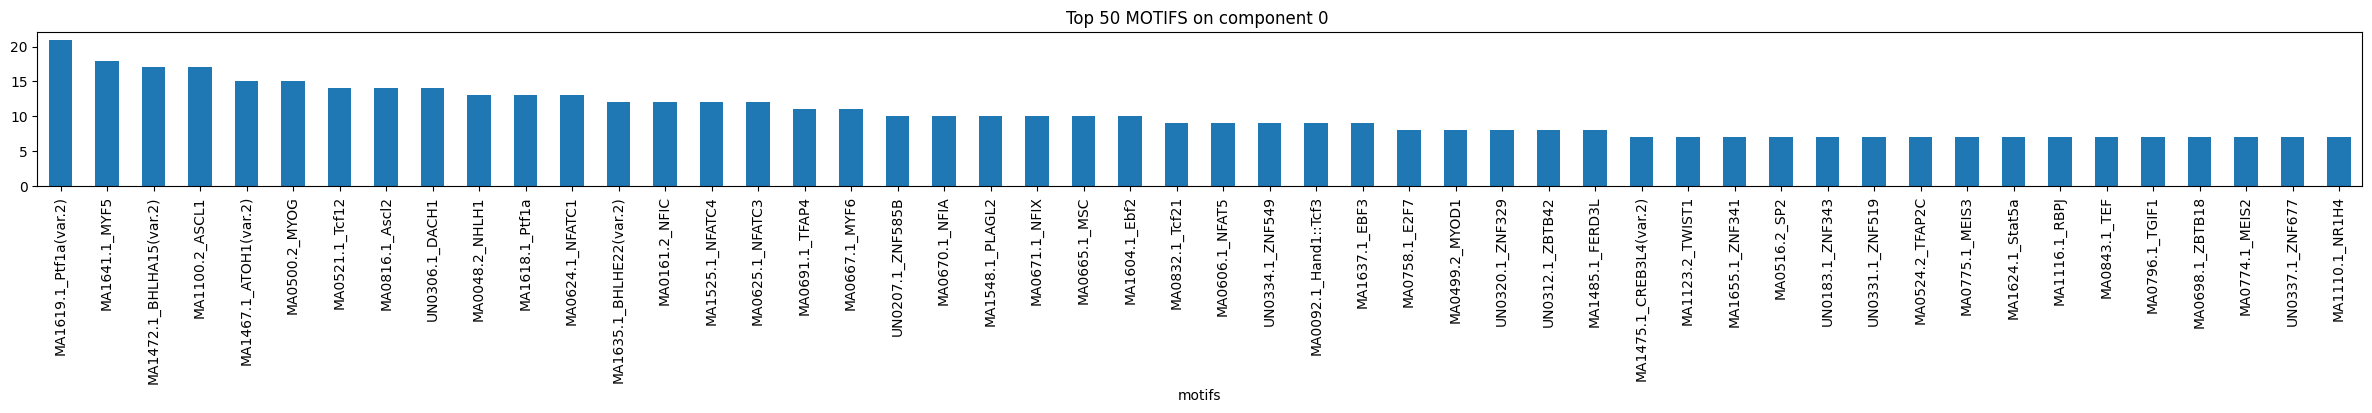

15
Computing Motifs....
scanning: 100%|███████████████████████| 238/238 [00:06<00:00, 38.44 sequences/s]


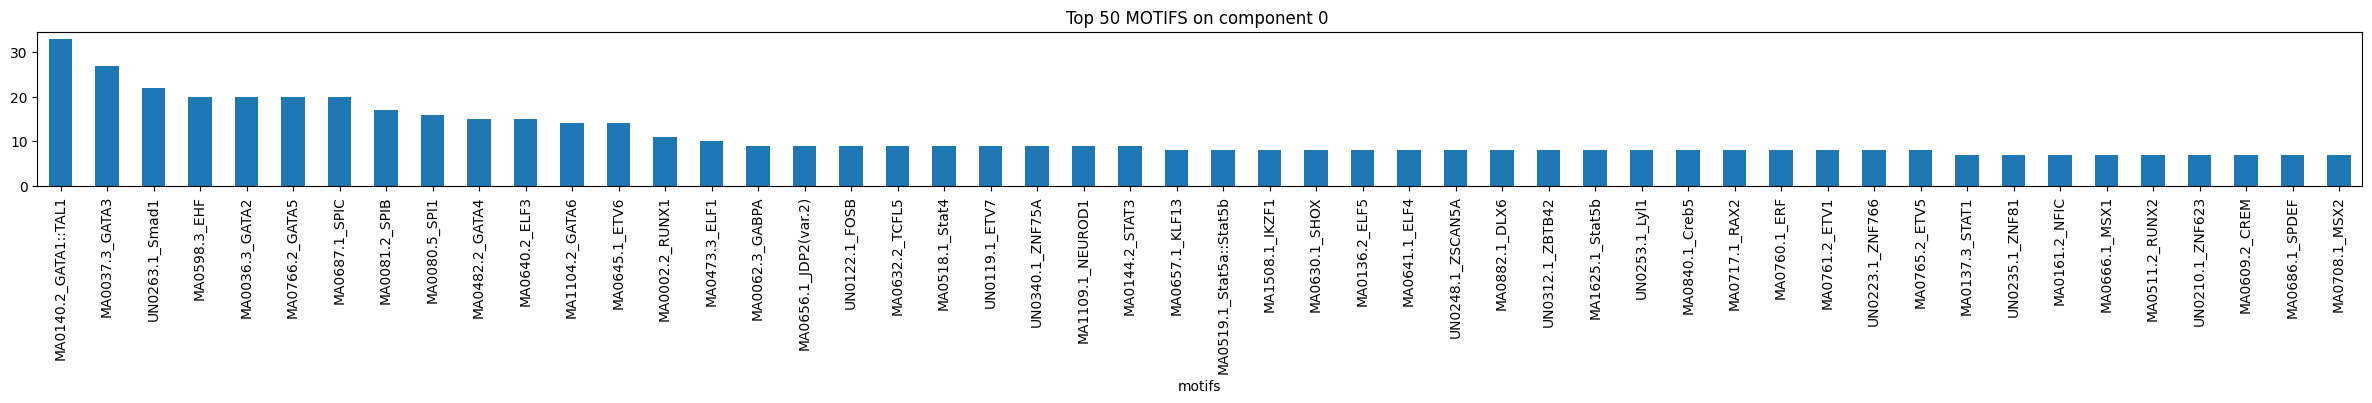

Generating Fasta and Motis: train_shuffle
------------------------------
Generating Motifs (all seqs)
Computing Motifs....
scanning: 100%|█████████████████████| 1000/1000 [00:11<00:00, 83.86 sequences/s]


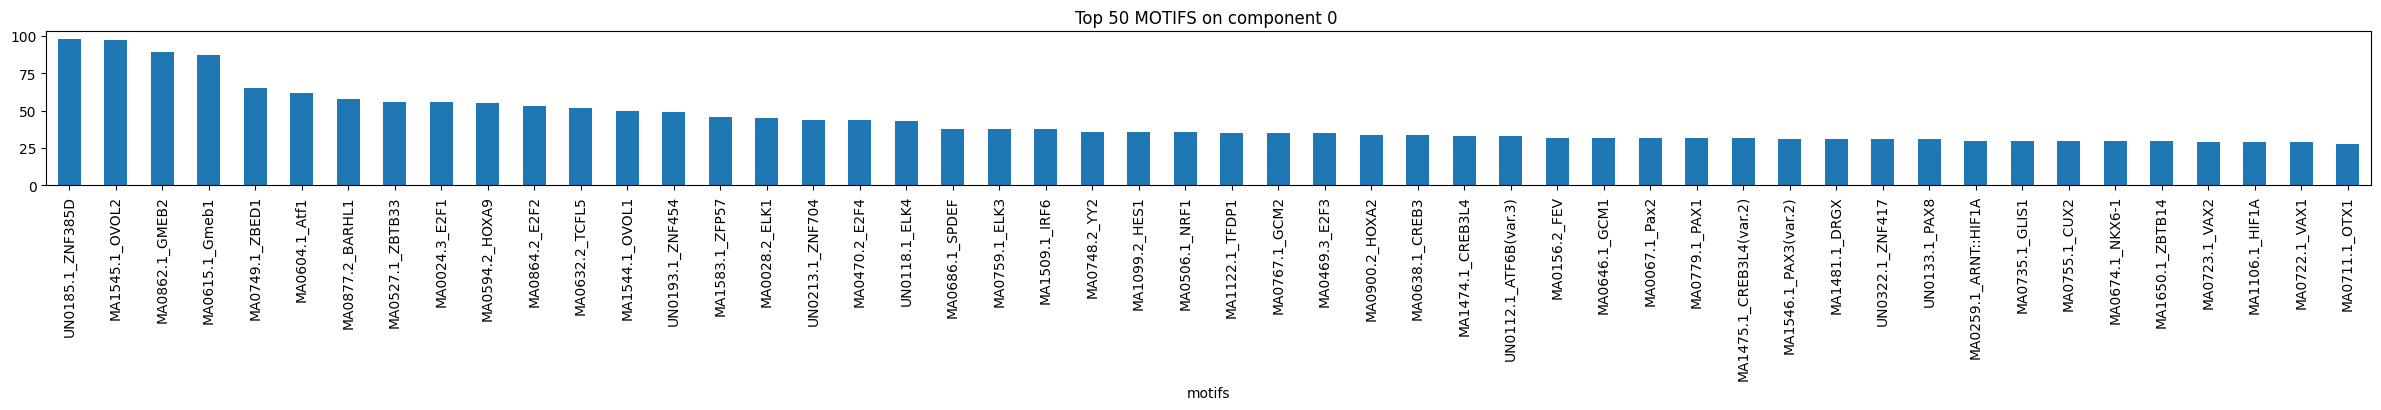

Generating Motifs per component
3
Computing Motifs....
scanning: 100%|███████████████████████| 255/255 [00:06<00:00, 40.91 sequences/s]


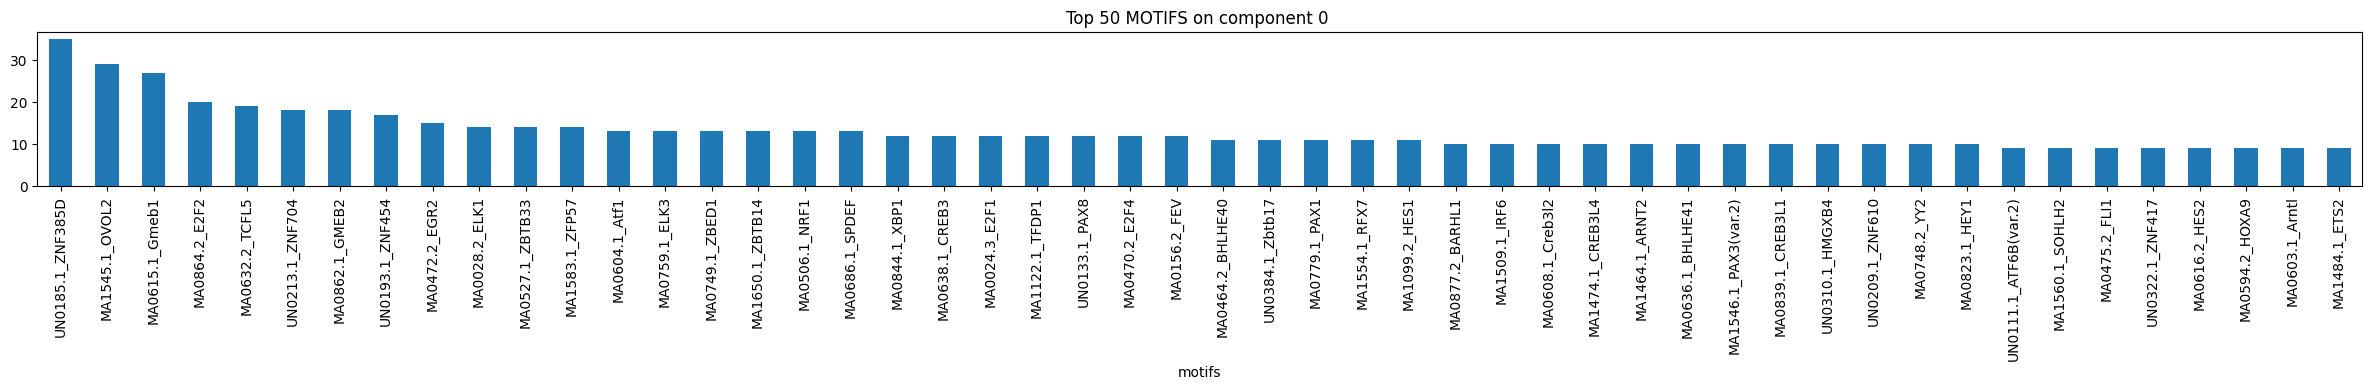

8
Computing Motifs....
scanning: 100%|███████████████████████| 249/249 [00:06<00:00, 39.04 sequences/s]


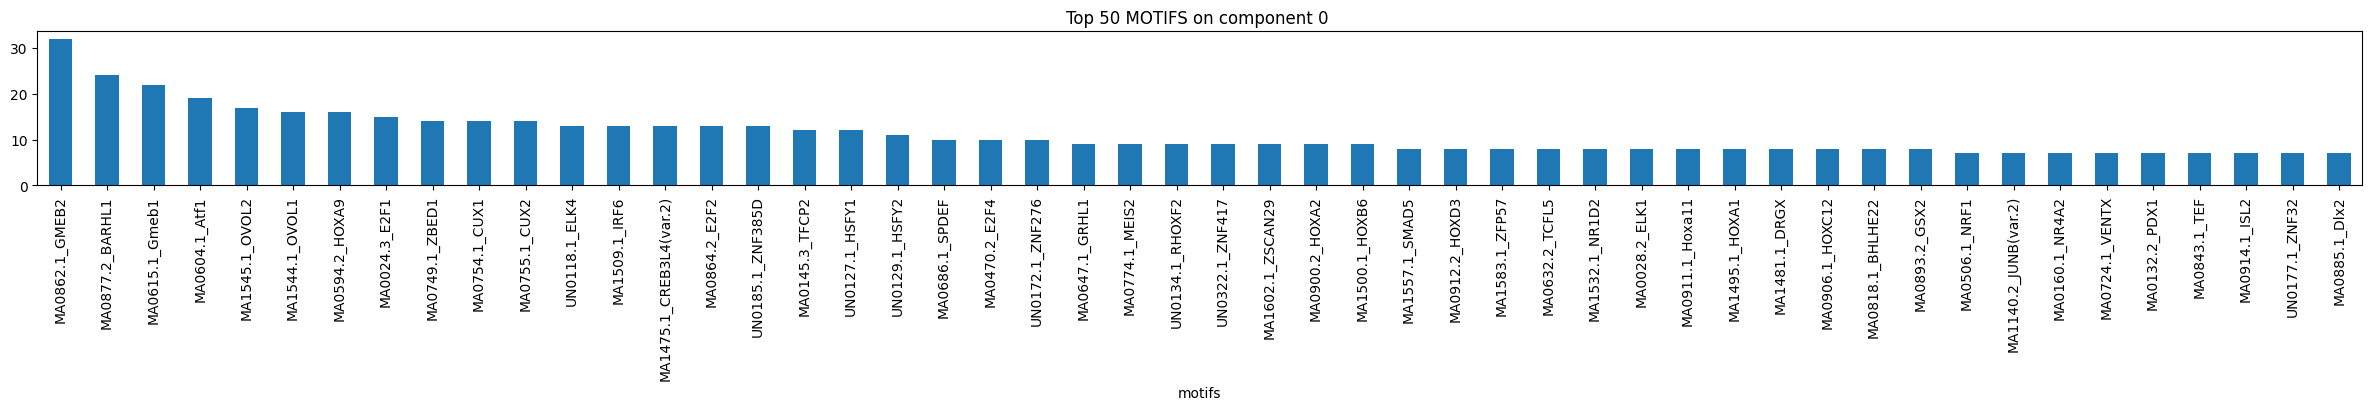

12
Computing Motifs....
scanning: 100%|███████████████████████| 245/245 [00:06<00:00, 40.22 sequences/s]


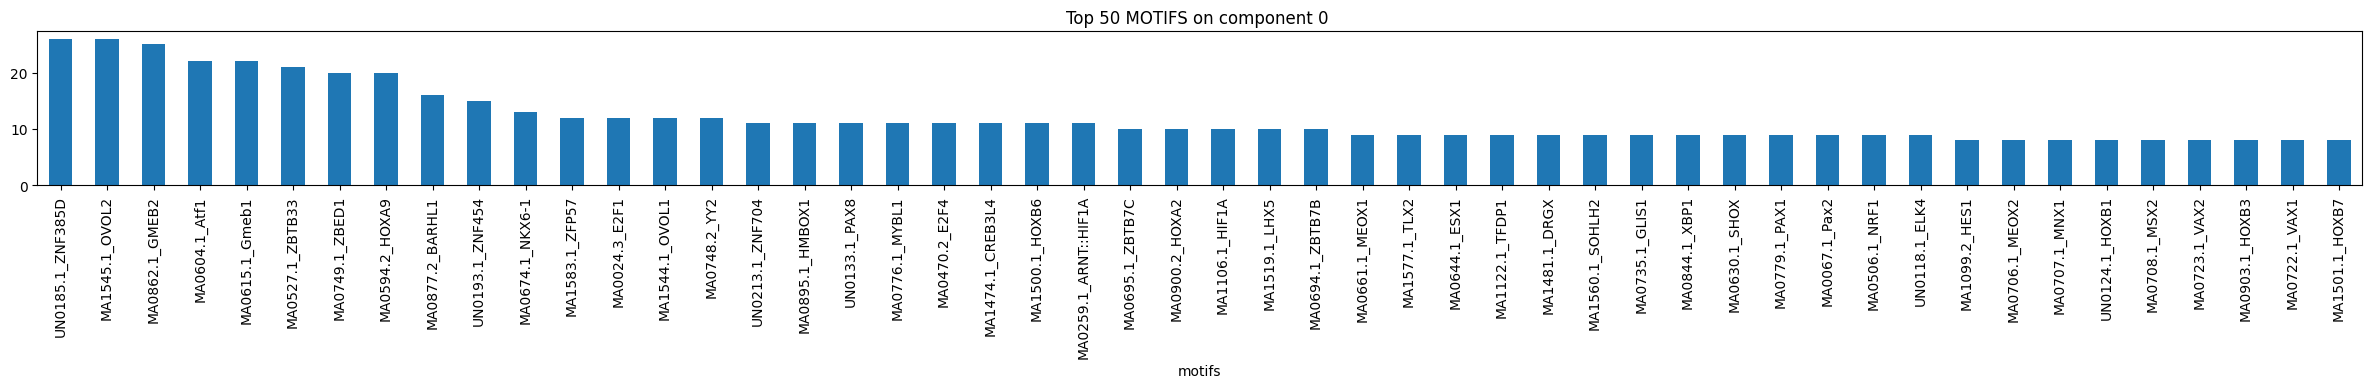

15
Computing Motifs....
scanning: 100%|███████████████████████| 251/251 [00:06<00:00, 40.35 sequences/s]


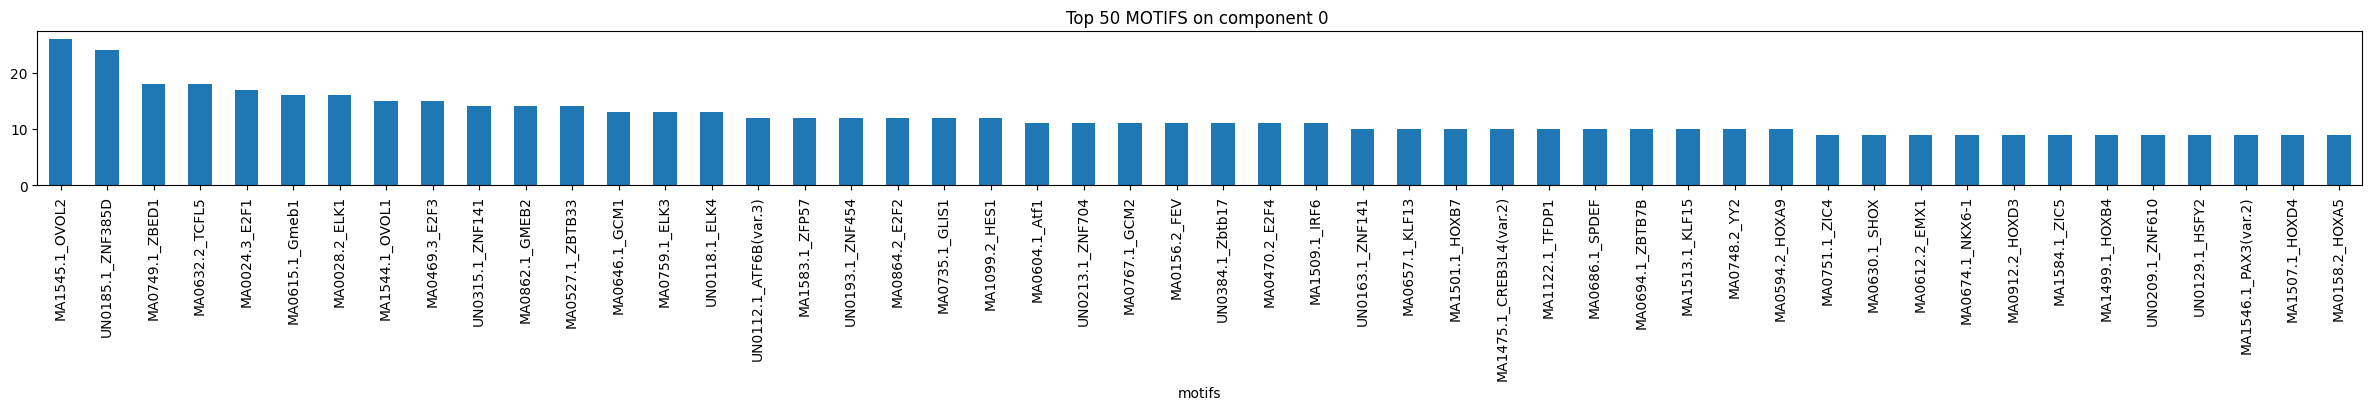

In [69]:
import random

def motifs_from_fasta(fasta, generate_heatmap=True):
    print ('Computing Motifs....')
    !gimme scan $fasta -p  JASPAR2020_vertebrates -g hg38 > train_results_motifs.bed
    df_results_seq_guime = pd.read_csv('train_results_motifs.bed', sep='\t', skiprows=5, header=None)
    df_results_seq_guime['motifs'] = df_results_seq_guime[8].apply(lambda x: x.split( 'motif_name "'    )[1].split('"')[0]   )
    # if generate_heatmap:
    #     generate_heatmap_motifs(df_results_seq_guime)

    df_results_seq_guime[0] = df_results_seq_guime[0].apply(lambda x : '_'.join(  x.split('_')[:-1])    )
    df_results_seq_guime_count_out = df_results_seq_guime[[0,'motifs']].drop_duplicates().groupby('motifs').count()
    plt.rcParams["figure.figsize"] = (30,2)
    df_results_seq_guime_count_out.sort_values(0, ascending=False).head(50)[0].plot.bar()
    plt.title('Top 50 MOTIFS on component 0 ')
    plt.show()
    return df_results_seq_guime_count_out


class LoadingData():
    def __init__(self,input_csv,sample_number=1000,subset_components=None, plot=True, change_component_index = True, ):
        '''subset_components: (NONE) list
                subset components should be a list of components to extract ex: [3,12,4,3]
           sample_number : 1000
               Total number o sequences
         '''
        
        self.csv = input_csv
        self.plot = plot
        self.sample_number= sample_number
        self.subset_components = subset_components    # case none I need add all
        self.change_comp_index = change_component_index
        self.data =  self.read_csv()
        self.df_generate = self.experiment() 
        self.df_train_in, self.df_test_in , self.df_train_shuffled_in = self.create_train_groups()
        
        self.train = None
        self.test = None
        self.train_shuffle = None
        self.get_motif()
        
    def read_csv(self):
        df =  pd.read_csv( self.csv , sep="\t")
        if self.change_comp_index:
            df['component']= df['component'] + 1
        return df
    def experiment(self):
        df_generate = self.data.copy()
        if self.subset_components != None and type(self.subset_components) == list:
            df_generate = df_generate.query( ' or '.join([f'component == {c}' for c in self.subset_components])).copy()
            print ('Subseting...')
        
        if self.plot:
            (df_generate.groupby('component').count()['raw_sequence']  / df_generate.groupby('component').count()['raw_sequence'].sum() ).plot.bar()
            plt.title('Component % on Training Sample')
            plt.show()

        return df_generate
    
    
    def create_train_groups(self):
        
        df_sampled = self.df_generate.sample(self.sample_number*2) #getting train and test
        df_train = df_sampled.iloc[:self.sample_number].copy()
        df_test = df_sampled.iloc[self.sample_number:].copy()
        df_train_shuffled = df_train.copy()
        df_train_shuffled['raw_sequence'] = df_train_shuffled['raw_sequence'].apply(lambda x : ''.join(random.sample(list(x), len(x)))  )
        return df_train , df_test , df_train_shuffled
        
        
    def get_motif(self):
        self.train = self.generate_motifs_and_fastas(self.df_train_in,  'train')
        self.test = self.generate_motifs_and_fastas(self.df_test_in, 'test')
        self.train_shuffle = self.generate_motifs_and_fastas(self.df_train_shuffled_in,'train_shuffle')
        
        
    def generate_motifs_and_fastas(self, df,name):
        '''return fasta anem , and dict with components motifs'''
        print ('Generating Fasta and Motis:', name)
        print ('---' * 10)
        fasta_saved = self.save_fasta(df, f"{name}_{self.sample_number}_{'_'.join([str(c) for c in self.subset_components])}")
        print('Generating Motifs (all seqs)')
        motif_all_components = motifs_from_fasta(fasta_saved, False)
        print('Generating Motifs per component')
        train_comp_motifs_dict = self.generate_motifs_components(df)
        
                

        
        
        return {'fasta_name':fasta_saved ,
                'motifs': motif_all_components ,    
                'motifs_per_components_dict':train_comp_motifs_dict ,
                'dataset': df}
    
    
        
    def save_fasta(self, df , name_fasta):
        fasta_final_name = name_fasta + '.fasta'
        save_fasta_file= open(fasta_final_name, 'w')
        write_fasta_component = '\n'.join(df[['Unnamed: 0', 'raw_sequence', 'component']].apply(lambda x : f'>{x[0]}_component_{x[2]}\n{x[1]}', axis=1).values.tolist())
        save_fasta_file.write(write_fasta_component)
        save_fasta_file.close()
        return fasta_final_name
    
    
    def generate_motifs_components(self, df):
        final_comp_values = {}
        for comp,v_comp in df.groupby('component'):
            print (comp)
            name_c_fasta = self.save_fasta(v_comp, 'temp_component')
            final_comp_values[comp] = motifs_from_fasta(name_c_fasta, False)
        return final_comp_values


encode_data = LoadingData("train_all_classifier_WM20220916.csv" , sample_number = 1000 ,subset_components=[3,8,12,15])



In [112]:
df_results_seq_guime_count_train = encode_data.train['motifs']
df_results_seq_guime_count_test = encode_data.test['motifs']
df_results_seq_guime_count_shuffle = encode_data.train_shuffle['motifs']


final_comp_values_trian = encode_data.train['motifs_per_components_dict']
final_comp_values_test = encode_data.test['motifs_per_components_dict']
final_comp_values_shuffle = encode_data.train_shuffle[
    'motifs_per_components_dict'
]


df = encode_data.train['dataset']
cell_components = (
    df.sort_values('component')['component'].unique().tolist()
)  # I need to add this function inside the dataloader

In [65]:
names_comp = '''7 Trophoblasts
5 CD8_cells
15 CD34_cells
9 Fetal_heart
12 Fetal_muscle
14 HMVEC(vascular)
3 hESC(Embryionic)
8 Fetal(Neural)
13 Intestine
2 Skin(stromalA)
4 Fibroblast(stromalB)
6 Renal(Cancer)
16 Esophageal(Cancer)
11 Fetal_Lung
10 Fetal_kidney
1 Tissue_Invariant'''.split(
    '\n'
)

labels_test = {int(x.split(' ')[0]): x.split(' ')[1] for x in names_comp}

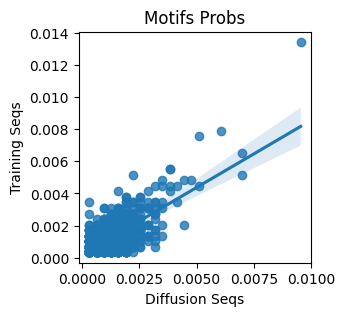

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        2        3        0.000637       0.001032
1    UN0249.1_ZSCAN9        4        3        0.001273       0.001032
2       MA0663.1_MLX        2        2        0.000637       0.000688
3     MA0160.1_NR4A2        5        7        0.001592       0.002408
4     MA0910.2_HOXD8        4        6        0.001273       0.002064
..               ...      ...      ...             ...            ...
849    MA1491.1_GLI3        8        9        0.002547       0.003096
850   MA0775.1_MEIS3        5        4        0.001592       0.001376
851   MA1505.1_HOXC8        6        3        0.001910       0.001032
852   MA1111.1_NR2F2        2        1        0.000637       0.000344
853    MA0641.1_ELF4        4        2        0.001273       0.000688

[854 rows x 5 columns]

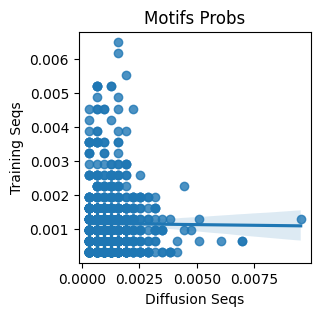

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        2        1        0.000636       0.000324
1    UN0249.1_ZSCAN9        4        1        0.001271       0.000324
2       MA0663.1_MLX        2        6        0.000636       0.001945
3     MA0160.1_NR4A2        5        4        0.001589       0.001297
4     MA0910.2_HOXD8        4        5        0.001271       0.001621
..               ...      ...      ...             ...            ...
854    MA1491.1_GLI3        8        1        0.002543       0.000324
855   MA0775.1_MEIS3        5       10        0.001589       0.003241
856   MA1505.1_HOXC8        6        5        0.001907       0.001621
857   MA1111.1_NR2F2        2        1        0.000636       0.000324
858    MA0641.1_ELF4        4        1        0.001271       0.000324

[859 rows x 5 columns]

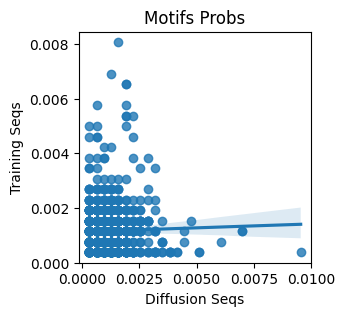

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        2        4        0.000636       0.001536
1    UN0249.1_ZSCAN9        4        4        0.001272       0.001536
2       MA0663.1_MLX        2        2        0.000636       0.000768
3     MA0160.1_NR4A2        5        3        0.001590       0.001152
4     MA0910.2_HOXD8        4        2        0.001272       0.000768
..               ...      ...      ...             ...            ...
853    MA1491.1_GLI3        8        6        0.002544       0.002304
854   MA0775.1_MEIS3        5        7        0.001590       0.002688
855   MA1505.1_HOXC8        6        1        0.001908       0.000384
856   MA1111.1_NR2F2        2        1        0.000636       0.000384
857    MA0641.1_ELF4        4        3        0.001272       0.001152

[858 rows x 5 columns]

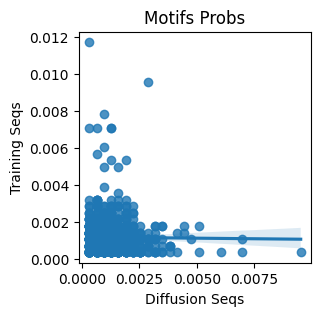

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        2        5        0.000636       0.001777
1    UN0249.1_ZSCAN9        4        3        0.001271       0.001066
2       MA0663.1_MLX        2        4        0.000636       0.001421
3     MA0160.1_NR4A2        5        3        0.001589       0.001066
4     MA0910.2_HOXD8        4        1        0.001271       0.000355
..               ...      ...      ...             ...            ...
855    MA1491.1_GLI3        8        2        0.002542       0.000711
856   MA0775.1_MEIS3        5        3        0.001589       0.001066
857   MA1505.1_HOXC8        6        2        0.001907       0.000711
858   MA1111.1_NR2F2        2        3        0.000636       0.001066
859    MA0641.1_ELF4        4        8        0.001271       0.002843

[860 rows x 5 columns]

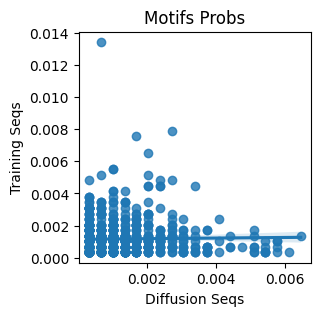

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        3        0.001021       0.001032
1    UN0249.1_ZSCAN9        2        3        0.000681       0.001032
2       MA0663.1_MLX        2        2        0.000681       0.000688
3     MA0160.1_NR4A2        3        7        0.001021       0.002408
4     MA0910.2_HOXD8        5        6        0.001702       0.002064
..               ...      ...      ...             ...            ...
849    MA1491.1_GLI3        2        9        0.000681       0.003096
850   MA0775.1_MEIS3        7        4        0.002383       0.001376
851   MA1505.1_HOXC8        8        3        0.002723       0.001032
852   MA1111.1_NR2F2        1        1        0.000340       0.000344
853    MA0641.1_ELF4        1        2        0.000340       0.000688

[854 rows x 5 columns]

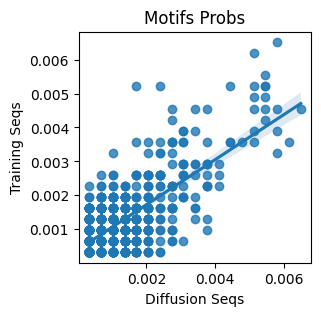

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        1        0.001024       0.000326
1    UN0249.1_ZSCAN9        2        1        0.000683       0.000326
2       MA0663.1_MLX        2        6        0.000683       0.001953
3     MA0160.1_NR4A2        3        4        0.001024       0.001302
4     MA0910.2_HOXD8        5        5        0.001706       0.001628
..               ...      ...      ...             ...            ...
841  UN0238.1_ZNF823        1        1        0.000341       0.000326
842    MA1491.1_GLI3        2        1        0.000683       0.000326
843   MA0775.1_MEIS3        7       10        0.002389       0.003255
844   MA1505.1_HOXC8        8        5        0.002730       0.001628
845    MA0641.1_ELF4        1        1        0.000341       0.000326

[846 rows x 5 columns]

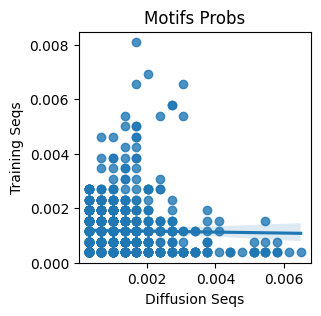

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        4        0.001022       0.001541
1    UN0249.1_ZSCAN9        2        4        0.000682       0.001541
2       MA0663.1_MLX        2        2        0.000682       0.000770
3     MA0160.1_NR4A2        3        3        0.001022       0.001156
4     MA0910.2_HOXD8        5        2        0.001704       0.000770
..               ...      ...      ...             ...            ...
845  UN0238.1_ZNF823        1        2        0.000341       0.000770
846    MA1491.1_GLI3        2        6        0.000682       0.002311
847   MA0775.1_MEIS3        7        7        0.002386       0.002696
848   MA1505.1_HOXC8        8        1        0.002727       0.000385
849    MA0641.1_ELF4        1        3        0.000341       0.001156

[850 rows x 5 columns]

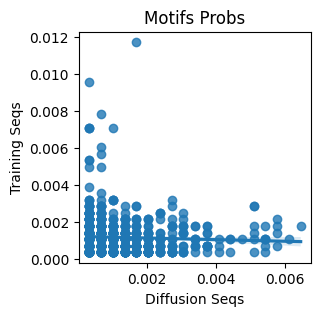

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        5        0.001019       0.001777
1    UN0249.1_ZSCAN9        2        3        0.000679       0.001066
2       MA0663.1_MLX        2        4        0.000679       0.001421
3     MA0160.1_NR4A2        3        3        0.001019       0.001066
4     MA0910.2_HOXD8        5        1        0.001698       0.000355
..               ...      ...      ...             ...            ...
855    MA1491.1_GLI3        2        2        0.000679       0.000711
856   MA0775.1_MEIS3        7        3        0.002378       0.001066
857   MA1505.1_HOXC8        8        2        0.002717       0.000711
858   MA1111.1_NR2F2        1        3        0.000340       0.001066
859    MA0641.1_ELF4        1        8        0.000340       0.002843

[860 rows x 5 columns]

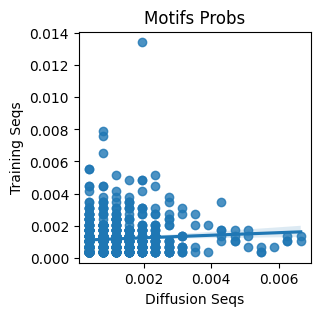

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        3        0.001174       0.001033
1    UN0249.1_ZSCAN9        2        3        0.000783       0.001033
2       MA0663.1_MLX        6        2        0.002348       0.000689
3     MA0160.1_NR4A2        4        7        0.001566       0.002411
4     MA0910.2_HOXD8        2        6        0.000783       0.002067
..               ...      ...      ...             ...            ...
845    MA1491.1_GLI3        8        9        0.003131       0.003100
846   MA0775.1_MEIS3       11        4        0.004305       0.001378
847   MA1505.1_HOXC8        1        3        0.000391       0.001033
848   MA1111.1_NR2F2        1        1        0.000391       0.000344
849    MA0641.1_ELF4        5        2        0.001957       0.000689

[850 rows x 5 columns]

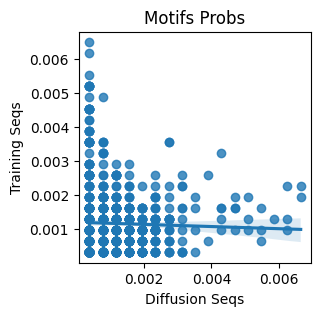

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        1        0.001171       0.000324
1    UN0249.1_ZSCAN9        2        1        0.000781       0.000324
2       MA0663.1_MLX        6        6        0.002343       0.001947
3     MA0160.1_NR4A2        4        4        0.001562       0.001298
4     MA0910.2_HOXD8        2        5        0.000781       0.001622
..               ...      ...      ...             ...            ...
851  UN0238.1_ZNF823        2        1        0.000781       0.000324
852    MA1491.1_GLI3        8        1        0.003124       0.000324
853   MA0775.1_MEIS3       11       10        0.004295       0.003245
854   MA1505.1_HOXC8        1        5        0.000390       0.001622
855    MA0641.1_ELF4        5        1        0.001952       0.000324

[856 rows x 5 columns]

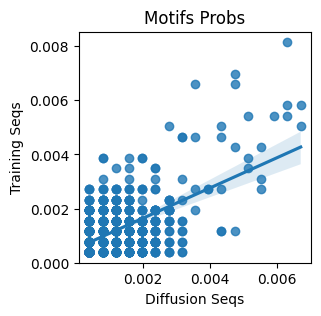

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        4        0.001182       0.001551
1    UN0249.1_ZSCAN9        2        4        0.000788       0.001551
2       MA0663.1_MLX        6        2        0.002364       0.000775
3     MA0160.1_NR4A2        4        3        0.001576       0.001163
4     MA0910.2_HOXD8        2        2        0.000788       0.000775
..               ...      ...      ...             ...            ...
828  UN0238.1_ZNF823        2        2        0.000788       0.000775
829    MA1491.1_GLI3        8        6        0.003152       0.002326
830   MA0775.1_MEIS3       11        7        0.004334       0.002714
831   MA1505.1_HOXC8        1        1        0.000394       0.000388
832    MA0641.1_ELF4        5        3        0.001970       0.001163

[833 rows x 5 columns]

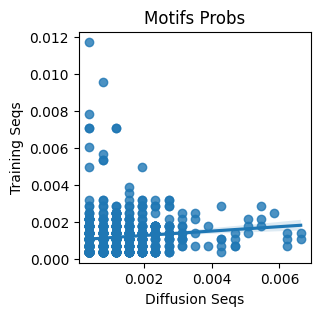

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        5        0.001170       0.001777
1    UN0249.1_ZSCAN9        2        3        0.000780       0.001066
2       MA0663.1_MLX        6        4        0.002339       0.001421
3     MA0160.1_NR4A2        4        3        0.001559       0.001066
4     MA0910.2_HOXD8        2        1        0.000780       0.000355
..               ...      ...      ...             ...            ...
855    MA1491.1_GLI3        8        2        0.003119       0.000711
856   MA0775.1_MEIS3       11        3        0.004288       0.001066
857   MA1505.1_HOXC8        1        2        0.000390       0.000711
858   MA1111.1_NR2F2        1        3        0.000390       0.001066
859    MA0641.1_ELF4        5        8        0.001949       0.002843

[860 rows x 5 columns]

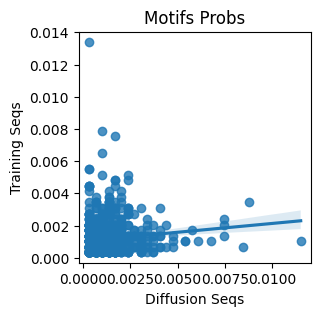

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        6        3        0.002030       0.001030
1    UN0249.1_ZSCAN9        2        3        0.000677       0.001030
2       MA0663.1_MLX        3        2        0.001015       0.000687
3     MA0160.1_NR4A2        4        7        0.001353       0.002403
4     MA0910.2_HOXD8        4        6        0.001353       0.002060
..               ...      ...      ...             ...            ...
855    MA1491.1_GLI3        3        9        0.001015       0.003090
856   MA0775.1_MEIS3        6        4        0.002030       0.001373
857   MA1505.1_HOXC8        1        3        0.000338       0.001030
858   MA1111.1_NR2F2        2        1        0.000677       0.000343
859    MA0641.1_ELF4       10        2        0.003383       0.000687

[860 rows x 5 columns]

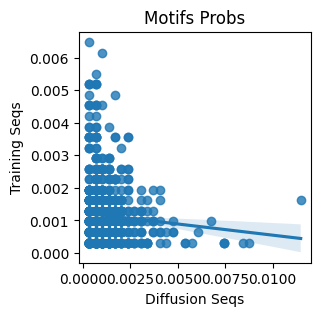

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        6        1        0.002026       0.000324
1    UN0249.1_ZSCAN9        2        1        0.000675       0.000324
2       MA0663.1_MLX        3        6        0.001013       0.001941
3     MA0160.1_NR4A2        4        4        0.001351       0.001294
4     MA0910.2_HOXD8        4        5        0.001351       0.001618
..               ...      ...      ...             ...            ...
860    MA1491.1_GLI3        3        1        0.001013       0.000324
861   MA0775.1_MEIS3        6       10        0.002026       0.003235
862   MA1505.1_HOXC8        1        5        0.000338       0.001618
863   MA1111.1_NR2F2        2        1        0.000675       0.000324
864    MA0641.1_ELF4       10        1        0.003377       0.000324

[865 rows x 5 columns]

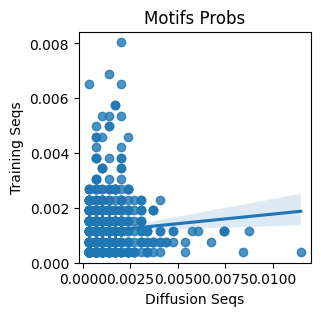

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        6        4        0.002027       0.001533
1    UN0249.1_ZSCAN9        2        4        0.000676       0.001533
2       MA0663.1_MLX        3        2        0.001014       0.000766
3     MA0160.1_NR4A2        4        3        0.001351       0.001149
4     MA0910.2_HOXD8        4        2        0.001351       0.000766
..               ...      ...      ...             ...            ...
859    MA1491.1_GLI3        3        6        0.001014       0.002299
860   MA0775.1_MEIS3        6        7        0.002027       0.002682
861   MA1505.1_HOXC8        1        1        0.000338       0.000383
862   MA1111.1_NR2F2        2        1        0.000676       0.000383
863    MA0641.1_ELF4       10        3        0.003378       0.001149

[864 rows x 5 columns]

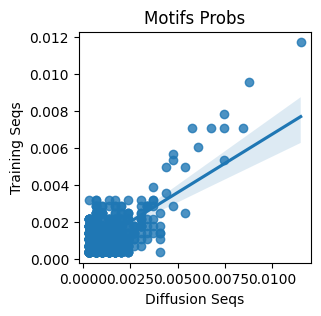

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        6        5        0.002029       0.001776
1    UN0249.1_ZSCAN9        2        3        0.000676       0.001066
2       MA0663.1_MLX        3        4        0.001015       0.001421
3     MA0160.1_NR4A2        4        3        0.001353       0.001066
4     MA0910.2_HOXD8        4        1        0.001353       0.000355
..               ...      ...      ...             ...            ...
856    MA1491.1_GLI3        3        2        0.001015       0.000710
857   MA0775.1_MEIS3        6        3        0.002029       0.001066
858   MA1505.1_HOXC8        1        2        0.000338       0.000710
859   MA1111.1_NR2F2        2        3        0.000676       0.001066
860    MA0641.1_ELF4       10        8        0.003382       0.002842

[861 rows x 5 columns]

{3:                  0
 motifs            
 MA0002.2_RUNX1   3
 MA0003.4_TFAP2A  3
 MA0007.3_Ar      1
 MA0009.2_TBXT    4
 MA0014.3_PAX5    1
 ...             ..
 UN0339.1_ZNF708  5
 UN0340.1_ZNF75A  5
 UN0341.1_ZNF768  3
 UN0383.1_Nanog   6
 UN0384.1_Zbtb17  6
 
 [784 rows x 1 columns],
 8:                  0
 motifs            
 MA0002.2_RUNX1   1
 MA0003.4_TFAP2A  5
 MA0007.3_Ar      3
 MA0009.2_TBXT    3
 MA0014.3_PAX5    1
 ...             ..
 UN0338.1_ZNF680  3
 UN0339.1_ZNF708  8
 UN0340.1_ZNF75A  1
 UN0341.1_ZNF768  2
 UN0384.1_Zbtb17  2
 
 [753 rows x 1 columns],
 12:                  0
 motifs            
 MA0002.2_RUNX1   4
 MA0003.4_TFAP2A  5
 MA0007.3_Ar      4
 MA0014.3_PAX5    3
 MA0017.2_NR2F1   4
 ...             ..
 UN0338.1_ZNF680  2
 UN0339.1_ZNF708  3
 UN0340.1_ZNF75A  4
 UN0383.1_Nanog   1
 UN0384.1_Zbtb17  4
 
 [745 rows x 1 columns],
 15:                   0
 motifs             
 MA0002.2_RUNX1   11
 MA0003.4_TFAP2A   4
 MA0007.3_Ar       4
 MA0009.2_TBXT     3

In [74]:
def kl_comparison_between_dataset(first_dic, second_dict):
    final_comp_kl = []
    for k, v in first_dic.items():
        comp_array = []
        for k_second in second_dict.keys():
            kl_out = compare_motif_list(v, second_dict[k_second])
            comp_array.append(kl_out)
        final_comp_kl.append(comp_array)
    return final_comp_kl

In [155]:
def generate_heatmap_components(df_heat, x_label, y_label):
    plt.rcParams["figure.figsize"] = (10, 10)
    df_plot = pd.DataFrame(df_heat)
    df_plot.columns = [labels_test[x] for x in cell_components]
    df_plot.index = df_plot.columns
    sns.heatmap(df_plot, cmap='Blues_r', annot=True, lw=0.1, vmax=1, vmin=0)
    plt.title(
        f'Kl divergence \n {x_label} sequences x  {y_label} sequences \n MOTIFS probabilities'
    )
    plt.xlabel(f'{x_label} Sequences  \n(motifs dist)')
    plt.ylabel(f'{y_label} \n (motifs dist)')

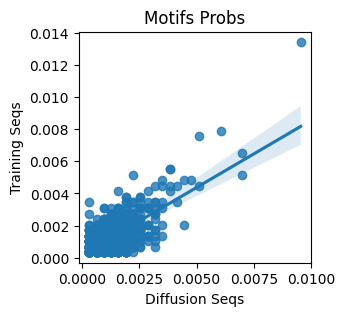

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        2        3        0.000637       0.001032
1    UN0249.1_ZSCAN9        4        3        0.001273       0.001032
2       MA0663.1_MLX        2        2        0.000637       0.000688
3     MA0160.1_NR4A2        5        7        0.001592       0.002408
4     MA0910.2_HOXD8        4        6        0.001273       0.002064
..               ...      ...      ...             ...            ...
849    MA1491.1_GLI3        8        9        0.002547       0.003096
850   MA0775.1_MEIS3        5        4        0.001592       0.001376
851   MA1505.1_HOXC8        6        3        0.001910       0.001032
852   MA1111.1_NR2F2        2        1        0.000637       0.000344
853    MA0641.1_ELF4        4        2        0.001273       0.000688

[854 rows x 5 columns]

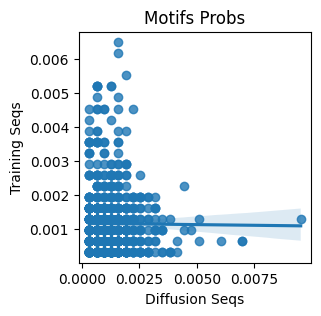

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        2        1        0.000636       0.000324
1    UN0249.1_ZSCAN9        4        1        0.001271       0.000324
2       MA0663.1_MLX        2        6        0.000636       0.001945
3     MA0160.1_NR4A2        5        4        0.001589       0.001297
4     MA0910.2_HOXD8        4        5        0.001271       0.001621
..               ...      ...      ...             ...            ...
854    MA1491.1_GLI3        8        1        0.002543       0.000324
855   MA0775.1_MEIS3        5       10        0.001589       0.003241
856   MA1505.1_HOXC8        6        5        0.001907       0.001621
857   MA1111.1_NR2F2        2        1        0.000636       0.000324
858    MA0641.1_ELF4        4        1        0.001271       0.000324

[859 rows x 5 columns]

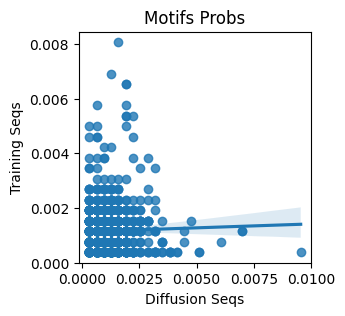

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        2        4        0.000636       0.001536
1    UN0249.1_ZSCAN9        4        4        0.001272       0.001536
2       MA0663.1_MLX        2        2        0.000636       0.000768
3     MA0160.1_NR4A2        5        3        0.001590       0.001152
4     MA0910.2_HOXD8        4        2        0.001272       0.000768
..               ...      ...      ...             ...            ...
853    MA1491.1_GLI3        8        6        0.002544       0.002304
854   MA0775.1_MEIS3        5        7        0.001590       0.002688
855   MA1505.1_HOXC8        6        1        0.001908       0.000384
856   MA1111.1_NR2F2        2        1        0.000636       0.000384
857    MA0641.1_ELF4        4        3        0.001272       0.001152

[858 rows x 5 columns]

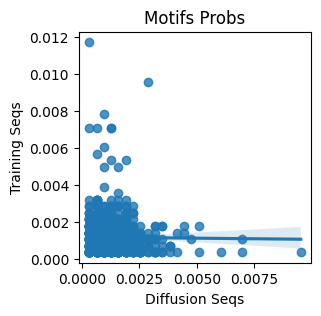

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        2        5        0.000636       0.001777
1    UN0249.1_ZSCAN9        4        3        0.001271       0.001066
2       MA0663.1_MLX        2        4        0.000636       0.001421
3     MA0160.1_NR4A2        5        3        0.001589       0.001066
4     MA0910.2_HOXD8        4        1        0.001271       0.000355
..               ...      ...      ...             ...            ...
855    MA1491.1_GLI3        8        2        0.002542       0.000711
856   MA0775.1_MEIS3        5        3        0.001589       0.001066
857   MA1505.1_HOXC8        6        2        0.001907       0.000711
858   MA1111.1_NR2F2        2        3        0.000636       0.001066
859    MA0641.1_ELF4        4        8        0.001271       0.002843

[860 rows x 5 columns]

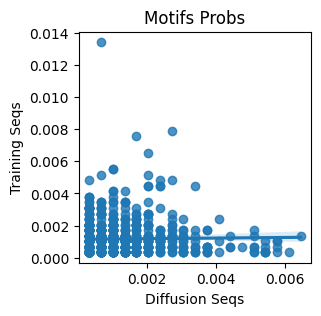

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        3        0.001021       0.001032
1    UN0249.1_ZSCAN9        2        3        0.000681       0.001032
2       MA0663.1_MLX        2        2        0.000681       0.000688
3     MA0160.1_NR4A2        3        7        0.001021       0.002408
4     MA0910.2_HOXD8        5        6        0.001702       0.002064
..               ...      ...      ...             ...            ...
849    MA1491.1_GLI3        2        9        0.000681       0.003096
850   MA0775.1_MEIS3        7        4        0.002383       0.001376
851   MA1505.1_HOXC8        8        3        0.002723       0.001032
852   MA1111.1_NR2F2        1        1        0.000340       0.000344
853    MA0641.1_ELF4        1        2        0.000340       0.000688

[854 rows x 5 columns]

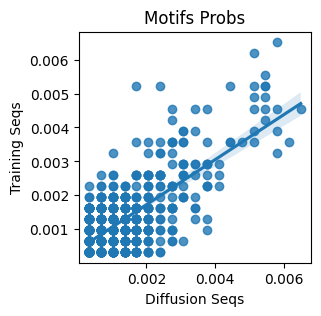

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        1        0.001024       0.000326
1    UN0249.1_ZSCAN9        2        1        0.000683       0.000326
2       MA0663.1_MLX        2        6        0.000683       0.001953
3     MA0160.1_NR4A2        3        4        0.001024       0.001302
4     MA0910.2_HOXD8        5        5        0.001706       0.001628
..               ...      ...      ...             ...            ...
841  UN0238.1_ZNF823        1        1        0.000341       0.000326
842    MA1491.1_GLI3        2        1        0.000683       0.000326
843   MA0775.1_MEIS3        7       10        0.002389       0.003255
844   MA1505.1_HOXC8        8        5        0.002730       0.001628
845    MA0641.1_ELF4        1        1        0.000341       0.000326

[846 rows x 5 columns]

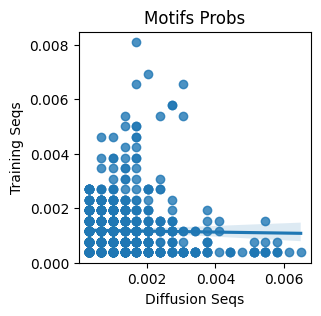

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        4        0.001022       0.001541
1    UN0249.1_ZSCAN9        2        4        0.000682       0.001541
2       MA0663.1_MLX        2        2        0.000682       0.000770
3     MA0160.1_NR4A2        3        3        0.001022       0.001156
4     MA0910.2_HOXD8        5        2        0.001704       0.000770
..               ...      ...      ...             ...            ...
845  UN0238.1_ZNF823        1        2        0.000341       0.000770
846    MA1491.1_GLI3        2        6        0.000682       0.002311
847   MA0775.1_MEIS3        7        7        0.002386       0.002696
848   MA1505.1_HOXC8        8        1        0.002727       0.000385
849    MA0641.1_ELF4        1        3        0.000341       0.001156

[850 rows x 5 columns]

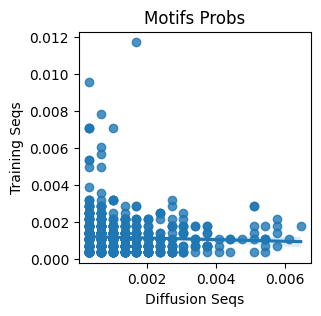

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        5        0.001019       0.001777
1    UN0249.1_ZSCAN9        2        3        0.000679       0.001066
2       MA0663.1_MLX        2        4        0.000679       0.001421
3     MA0160.1_NR4A2        3        3        0.001019       0.001066
4     MA0910.2_HOXD8        5        1        0.001698       0.000355
..               ...      ...      ...             ...            ...
855    MA1491.1_GLI3        2        2        0.000679       0.000711
856   MA0775.1_MEIS3        7        3        0.002378       0.001066
857   MA1505.1_HOXC8        8        2        0.002717       0.000711
858   MA1111.1_NR2F2        1        3        0.000340       0.001066
859    MA0641.1_ELF4        1        8        0.000340       0.002843

[860 rows x 5 columns]

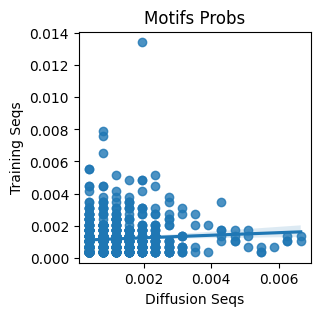

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        3        0.001174       0.001033
1    UN0249.1_ZSCAN9        2        3        0.000783       0.001033
2       MA0663.1_MLX        6        2        0.002348       0.000689
3     MA0160.1_NR4A2        4        7        0.001566       0.002411
4     MA0910.2_HOXD8        2        6        0.000783       0.002067
..               ...      ...      ...             ...            ...
845    MA1491.1_GLI3        8        9        0.003131       0.003100
846   MA0775.1_MEIS3       11        4        0.004305       0.001378
847   MA1505.1_HOXC8        1        3        0.000391       0.001033
848   MA1111.1_NR2F2        1        1        0.000391       0.000344
849    MA0641.1_ELF4        5        2        0.001957       0.000689

[850 rows x 5 columns]

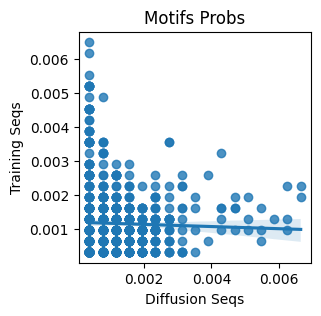

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        1        0.001171       0.000324
1    UN0249.1_ZSCAN9        2        1        0.000781       0.000324
2       MA0663.1_MLX        6        6        0.002343       0.001947
3     MA0160.1_NR4A2        4        4        0.001562       0.001298
4     MA0910.2_HOXD8        2        5        0.000781       0.001622
..               ...      ...      ...             ...            ...
851  UN0238.1_ZNF823        2        1        0.000781       0.000324
852    MA1491.1_GLI3        8        1        0.003124       0.000324
853   MA0775.1_MEIS3       11       10        0.004295       0.003245
854   MA1505.1_HOXC8        1        5        0.000390       0.001622
855    MA0641.1_ELF4        5        1        0.001952       0.000324

[856 rows x 5 columns]

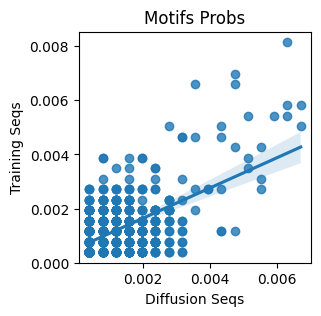

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        4        0.001182       0.001551
1    UN0249.1_ZSCAN9        2        4        0.000788       0.001551
2       MA0663.1_MLX        6        2        0.002364       0.000775
3     MA0160.1_NR4A2        4        3        0.001576       0.001163
4     MA0910.2_HOXD8        2        2        0.000788       0.000775
..               ...      ...      ...             ...            ...
828  UN0238.1_ZNF823        2        2        0.000788       0.000775
829    MA1491.1_GLI3        8        6        0.003152       0.002326
830   MA0775.1_MEIS3       11        7        0.004334       0.002714
831   MA1505.1_HOXC8        1        1        0.000394       0.000388
832    MA0641.1_ELF4        5        3        0.001970       0.001163

[833 rows x 5 columns]

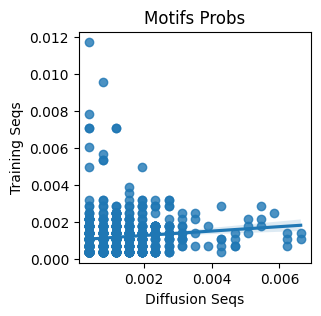

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        5        0.001170       0.001777
1    UN0249.1_ZSCAN9        2        3        0.000780       0.001066
2       MA0663.1_MLX        6        4        0.002339       0.001421
3     MA0160.1_NR4A2        4        3        0.001559       0.001066
4     MA0910.2_HOXD8        2        1        0.000780       0.000355
..               ...      ...      ...             ...            ...
855    MA1491.1_GLI3        8        2        0.003119       0.000711
856   MA0775.1_MEIS3       11        3        0.004288       0.001066
857   MA1505.1_HOXC8        1        2        0.000390       0.000711
858   MA1111.1_NR2F2        1        3        0.000390       0.001066
859    MA0641.1_ELF4        5        8        0.001949       0.002843

[860 rows x 5 columns]

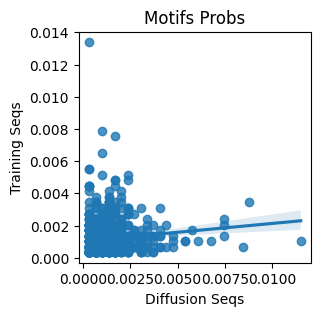

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        6        3        0.002030       0.001030
1    UN0249.1_ZSCAN9        2        3        0.000677       0.001030
2       MA0663.1_MLX        3        2        0.001015       0.000687
3     MA0160.1_NR4A2        4        7        0.001353       0.002403
4     MA0910.2_HOXD8        4        6        0.001353       0.002060
..               ...      ...      ...             ...            ...
855    MA1491.1_GLI3        3        9        0.001015       0.003090
856   MA0775.1_MEIS3        6        4        0.002030       0.001373
857   MA1505.1_HOXC8        1        3        0.000338       0.001030
858   MA1111.1_NR2F2        2        1        0.000677       0.000343
859    MA0641.1_ELF4       10        2        0.003383       0.000687

[860 rows x 5 columns]

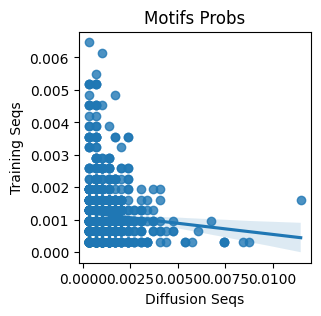

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        6        1        0.002026       0.000324
1    UN0249.1_ZSCAN9        2        1        0.000675       0.000324
2       MA0663.1_MLX        3        6        0.001013       0.001941
3     MA0160.1_NR4A2        4        4        0.001351       0.001294
4     MA0910.2_HOXD8        4        5        0.001351       0.001618
..               ...      ...      ...             ...            ...
860    MA1491.1_GLI3        3        1        0.001013       0.000324
861   MA0775.1_MEIS3        6       10        0.002026       0.003235
862   MA1505.1_HOXC8        1        5        0.000338       0.001618
863   MA1111.1_NR2F2        2        1        0.000675       0.000324
864    MA0641.1_ELF4       10        1        0.003377       0.000324

[865 rows x 5 columns]

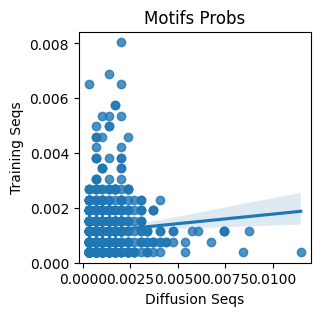

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        6        4        0.002027       0.001533
1    UN0249.1_ZSCAN9        2        4        0.000676       0.001533
2       MA0663.1_MLX        3        2        0.001014       0.000766
3     MA0160.1_NR4A2        4        3        0.001351       0.001149
4     MA0910.2_HOXD8        4        2        0.001351       0.000766
..               ...      ...      ...             ...            ...
859    MA1491.1_GLI3        3        6        0.001014       0.002299
860   MA0775.1_MEIS3        6        7        0.002027       0.002682
861   MA1505.1_HOXC8        1        1        0.000338       0.000383
862   MA1111.1_NR2F2        2        1        0.000676       0.000383
863    MA0641.1_ELF4       10        3        0.003378       0.001149

[864 rows x 5 columns]

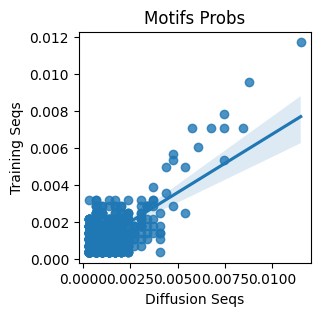

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        6        5        0.002029       0.001776
1    UN0249.1_ZSCAN9        2        3        0.000676       0.001066
2       MA0663.1_MLX        3        4        0.001015       0.001421
3     MA0160.1_NR4A2        4        3        0.001353       0.001066
4     MA0910.2_HOXD8        4        1        0.001353       0.000355
..               ...      ...      ...             ...            ...
856    MA1491.1_GLI3        3        2        0.001015       0.000710
857   MA0775.1_MEIS3        6        3        0.002029       0.001066
858   MA1505.1_HOXC8        1        2        0.000338       0.000710
859   MA1111.1_NR2F2        2        3        0.000676       0.001066
860    MA0641.1_ELF4       10        8        0.003382       0.002842

[861 rows x 5 columns]

In [122]:
heat_train_test = kl_comparison_between_dataset(
    final_comp_values_trian, final_comp_values_test
)

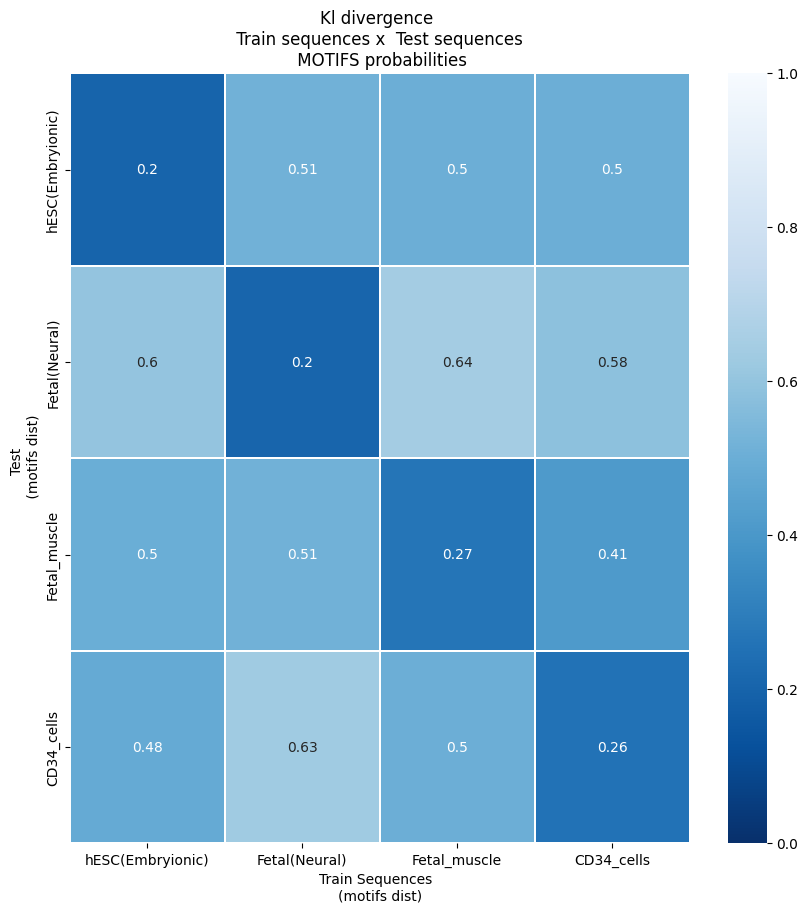

In [156]:
generate_heatmap_components(heat_train_test, 'Train', 'Test')

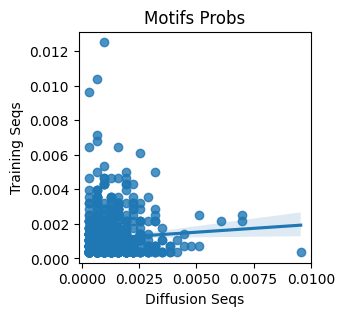

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        2        2        0.000637       0.000715
1    UN0249.1_ZSCAN9        4        1        0.001274       0.000357
2       MA0663.1_MLX        2        8        0.000637       0.002858
3     MA0160.1_NR4A2        5        6        0.001593       0.002144
4     MA0910.2_HOXD8        4        6        0.001274       0.002144
..               ...      ...      ...             ...            ...
847    MA1491.1_GLI3        8        6        0.002549       0.002144
848   MA0775.1_MEIS3        5        4        0.001593       0.001429
849   MA1505.1_HOXC8        6        1        0.001911       0.000357
850   MA1111.1_NR2F2        2        1        0.000637       0.000357
851    MA0641.1_ELF4        4        7        0.001274       0.002501

[852 rows x 5 columns]

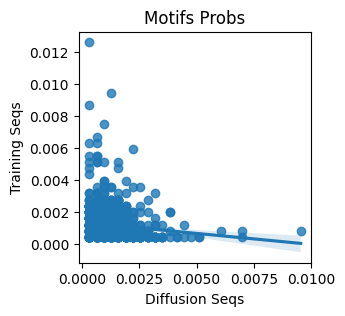

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        2        1        0.000636       0.000394
1    UN0249.1_ZSCAN9        4        3        0.001272       0.001181
2       MA0663.1_MLX        2        4        0.000636       0.001574
3     MA0160.1_NR4A2        5        7        0.001590       0.002755
4     MA0910.2_HOXD8        4        1        0.001272       0.000394
..               ...      ...      ...             ...            ...
853    MA1491.1_GLI3        8        2        0.002544       0.000787
854   MA0775.1_MEIS3        5        7        0.001590       0.002755
855   MA1505.1_HOXC8        6        5        0.001908       0.001968
856   MA1111.1_NR2F2        2        6        0.000636       0.002361
857    MA0641.1_ELF4        4        1        0.001272       0.000394

[858 rows x 5 columns]

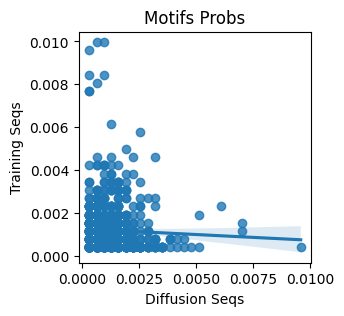

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        2        1        0.000639       0.000383
1    UN0249.1_ZSCAN9        4        1        0.001278       0.000383
2       MA0663.1_MLX        2        6        0.000639       0.002299
3     MA0160.1_NR4A2        5        1        0.001597       0.000383
4     MA0910.2_HOXD8        4        2        0.001278       0.000766
..               ...      ...      ...             ...            ...
838    MA1491.1_GLI3        8        1        0.002556       0.000383
839   MA0775.1_MEIS3        5        7        0.001597       0.002682
840   MA1505.1_HOXC8        6        8        0.001917       0.003065
841   MA1111.1_NR2F2        2        2        0.000639       0.000766
842    MA0641.1_ELF4        4        2        0.001278       0.000766

[843 rows x 5 columns]

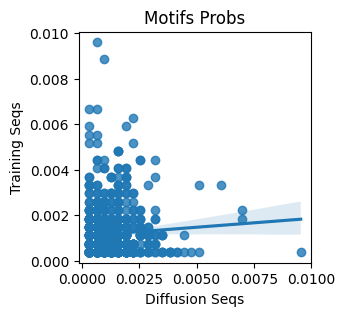

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        2        1        0.000637       0.000369
1    UN0249.1_ZSCAN9        4        1        0.001273       0.000369
2       MA0663.1_MLX        2        5        0.000637       0.001847
3     MA0160.1_NR4A2        5        1        0.001591       0.000369
4     MA0910.2_HOXD8        4        4        0.001273       0.001478
..               ...      ...      ...             ...            ...
850    MA1491.1_GLI3        8        4        0.002546       0.001478
851   MA0775.1_MEIS3        5        3        0.001591       0.001108
852   MA1505.1_HOXC8        6        3        0.001910       0.001108
853   MA1111.1_NR2F2        2        1        0.000637       0.000369
854    MA0641.1_ELF4        4        6        0.001273       0.002216

[855 rows x 5 columns]

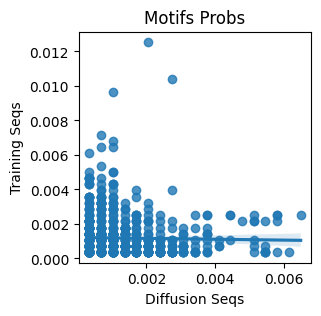

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        2        0.001024       0.000716
1    UN0249.1_ZSCAN9        2        1        0.000683       0.000358
2       MA0663.1_MLX        2        8        0.000683       0.002865
3     MA0160.1_NR4A2        3        6        0.001024       0.002149
4     MA0910.2_HOXD8        5        6        0.001707       0.002149
..               ...      ...      ...             ...            ...
840    MA1484.1_ETS2        1        9        0.000341       0.003223
841    MA1491.1_GLI3        2        6        0.000683       0.002149
842   MA0775.1_MEIS3        7        4        0.002390       0.001433
843   MA1505.1_HOXC8        8        1        0.002731       0.000358
844    MA0641.1_ELF4        1        7        0.000341       0.002507

[845 rows x 5 columns]

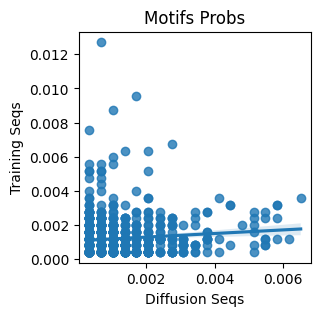

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        1        0.001028       0.000397
1    UN0249.1_ZSCAN9        2        3        0.000685       0.001192
2       MA0663.1_MLX        2        4        0.000685       0.001589
3     MA0160.1_NR4A2        3        7        0.001028       0.002781
4     MA0910.2_HOXD8        5        1        0.001714       0.000397
..               ...      ...      ...             ...            ...
829    MA1491.1_GLI3        2        2        0.000685       0.000795
830   MA0775.1_MEIS3        7        7        0.002399       0.002781
831   MA1505.1_HOXC8        8        5        0.002742       0.001986
832   MA1111.1_NR2F2        1        6        0.000343       0.002384
833    MA0641.1_ELF4        1        1        0.000343       0.000397

[834 rows x 5 columns]

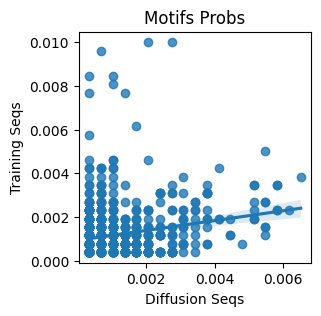

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        1        0.001029       0.000385
1    UN0249.1_ZSCAN9        2        1        0.000686       0.000385
2       MA0663.1_MLX        2        6        0.000686       0.002309
3     MA0160.1_NR4A2        3        1        0.001029       0.000385
4     MA0910.2_HOXD8        5        2        0.001715       0.000770
..               ...      ...      ...             ...            ...
827    MA1491.1_GLI3        2        1        0.000686       0.000385
828   MA0775.1_MEIS3        7        7        0.002401       0.002693
829   MA1505.1_HOXC8        8        8        0.002743       0.003078
830   MA1111.1_NR2F2        1        2        0.000343       0.000770
831    MA0641.1_ELF4        1        2        0.000343       0.000770

[832 rows x 5 columns]

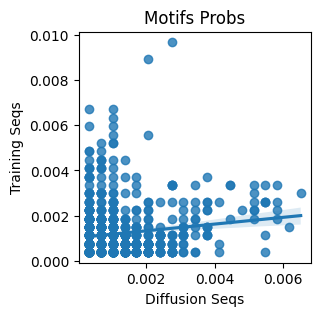

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        1        0.001029       0.000373
1    UN0249.1_ZSCAN9        2        1        0.000686       0.000373
2       MA0663.1_MLX        2        5        0.000686       0.001863
3     MA0160.1_NR4A2        3        1        0.001029       0.000373
4     MA0910.2_HOXD8        5        4        0.001715       0.001490
..               ...      ...      ...             ...            ...
827    MA1491.1_GLI3        2        4        0.000686       0.001490
828   MA0775.1_MEIS3        7        3        0.002401       0.001118
829   MA1505.1_HOXC8        8        3        0.002743       0.001118
830   MA1111.1_NR2F2        1        1        0.000343       0.000373
831    MA0641.1_ELF4        1        6        0.000343       0.002235

[832 rows x 5 columns]

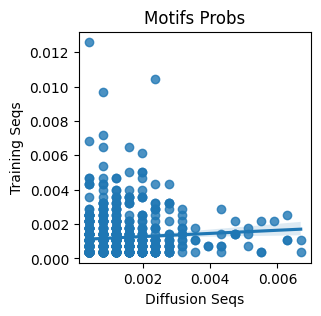

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        2        0.001182       0.000719
1    UN0249.1_ZSCAN9        2        1        0.000788       0.000360
2       MA0663.1_MLX        6        8        0.002363       0.002877
3     MA0160.1_NR4A2        4        6        0.001575       0.002157
4     MA0910.2_HOXD8        2        6        0.000788       0.002157
..               ...      ...      ...             ...            ...
829  UN0238.1_ZNF823        2        1        0.000788       0.000360
830    MA1491.1_GLI3        8        6        0.003151       0.002157
831   MA0775.1_MEIS3       11        4        0.004332       0.001438
832   MA1505.1_HOXC8        1        1        0.000394       0.000360
833    MA0641.1_ELF4        5        7        0.001969       0.002517

[834 rows x 5 columns]

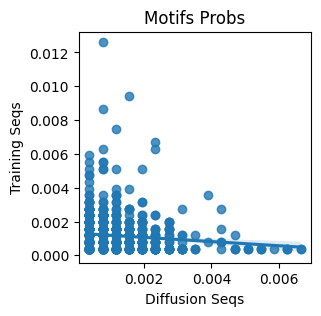

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        1        0.001171       0.000394
1    UN0249.1_ZSCAN9        2        3        0.000781       0.001182
2       MA0663.1_MLX        6        4        0.002343       0.001575
3     MA0160.1_NR4A2        4        7        0.001562       0.002757
4     MA0910.2_HOXD8        2        1        0.000781       0.000394
..               ...      ...      ...             ...            ...
851    MA1491.1_GLI3        8        2        0.003124       0.000788
852   MA0775.1_MEIS3       11        7        0.004295       0.002757
853   MA1505.1_HOXC8        1        5        0.000390       0.001969
854   MA1111.1_NR2F2        1        6        0.000390       0.002363
855    MA0641.1_ELF4        5        1        0.001952       0.000394

[856 rows x 5 columns]

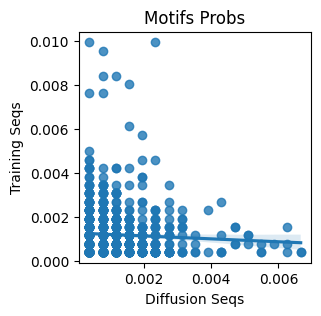

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        1        0.001175       0.000382
1    UN0249.1_ZSCAN9        2        1        0.000783       0.000382
2       MA0663.1_MLX        6        6        0.002350       0.002294
3     MA0160.1_NR4A2        4        1        0.001567       0.000382
4     MA0910.2_HOXD8        2        2        0.000783       0.000765
..               ...      ...      ...             ...            ...
843    MA1491.1_GLI3        8        1        0.003134       0.000382
844   MA0775.1_MEIS3       11        7        0.004309       0.002677
845   MA1505.1_HOXC8        1        8        0.000392       0.003059
846   MA1111.1_NR2F2        1        2        0.000392       0.000765
847    MA0641.1_ELF4        5        2        0.001958       0.000765

[848 rows x 5 columns]

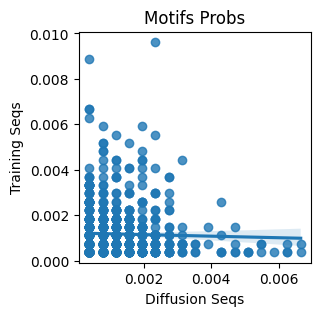

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        1        0.001173       0.000370
1    UN0249.1_ZSCAN9        2        1        0.000782       0.000370
2       MA0663.1_MLX        6        5        0.002346       0.001849
3     MA0160.1_NR4A2        4        1        0.001564       0.000370
4     MA0910.2_HOXD8        2        4        0.000782       0.001479
..               ...      ...      ...             ...            ...
847    MA1491.1_GLI3        8        4        0.003129       0.001479
848   MA0775.1_MEIS3       11        3        0.004302       0.001109
849   MA1505.1_HOXC8        1        3        0.000391       0.001109
850   MA1111.1_NR2F2        1        1        0.000391       0.000370
851    MA0641.1_ELF4        5        6        0.001955       0.002219

[852 rows x 5 columns]

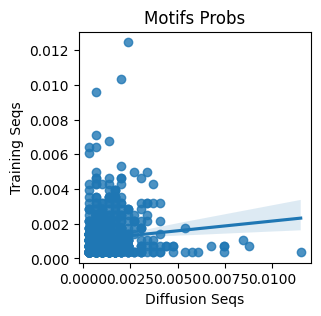

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        6        2        0.002029       0.000712
1    UN0249.1_ZSCAN9        2        1        0.000676       0.000356
2       MA0663.1_MLX        3        8        0.001015       0.002849
3     MA0160.1_NR4A2        4        6        0.001353       0.002137
4     MA0910.2_HOXD8        4        6        0.001353       0.002137
..               ...      ...      ...             ...            ...
856    MA1491.1_GLI3        3        6        0.001015       0.002137
857   MA0775.1_MEIS3        6        4        0.002029       0.001425
858   MA1505.1_HOXC8        1        1        0.000338       0.000356
859   MA1111.1_NR2F2        2        1        0.000676       0.000356
860    MA0641.1_ELF4       10        7        0.003382       0.002493

[861 rows x 5 columns]

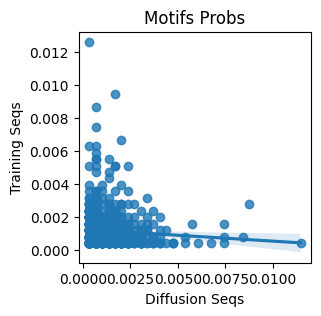

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        6        1        0.002027       0.000393
1    UN0249.1_ZSCAN9        2        3        0.000676       0.001178
2       MA0663.1_MLX        3        4        0.001014       0.001570
3     MA0160.1_NR4A2        4        7        0.001351       0.002748
4     MA0910.2_HOXD8        4        1        0.001351       0.000393
..               ...      ...      ...             ...            ...
859    MA1491.1_GLI3        3        2        0.001014       0.000785
860   MA0775.1_MEIS3        6        7        0.002027       0.002748
861   MA1505.1_HOXC8        1        5        0.000338       0.001963
862   MA1111.1_NR2F2        2        6        0.000676       0.002356
863    MA0641.1_ELF4       10        1        0.003378       0.000393

[864 rows x 5 columns]

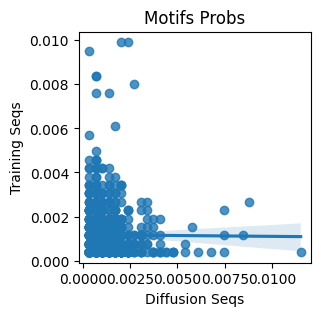

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        6        1        0.002033       0.000381
1    UN0249.1_ZSCAN9        2        1        0.000678       0.000381
2       MA0663.1_MLX        3        6        0.001016       0.002287
3     MA0160.1_NR4A2        4        1        0.001355       0.000381
4     MA0910.2_HOXD8        4        2        0.001355       0.000762
..               ...      ...      ...             ...            ...
851    MA1491.1_GLI3        3        1        0.001016       0.000381
852   MA0775.1_MEIS3        6        7        0.002033       0.002669
853   MA1505.1_HOXC8        1        8        0.000339       0.003050
854   MA1111.1_NR2F2        2        2        0.000678       0.000762
855    MA0641.1_ELF4       10        2        0.003388       0.000762

[856 rows x 5 columns]

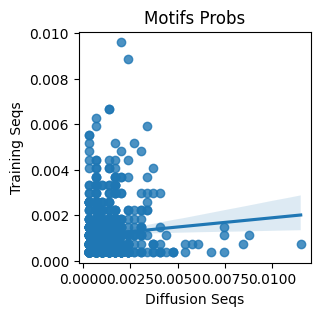

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        6        1        0.002031       0.000369
1    UN0249.1_ZSCAN9        2        1        0.000677       0.000369
2       MA0663.1_MLX        3        5        0.001016       0.001845
3     MA0160.1_NR4A2        4        1        0.001354       0.000369
4     MA0910.2_HOXD8        4        4        0.001354       0.001476
..               ...      ...      ...             ...            ...
853    MA1491.1_GLI3        3        4        0.001016       0.001476
854   MA0775.1_MEIS3        6        3        0.002031       0.001107
855   MA1505.1_HOXC8        1        3        0.000339       0.001107
856   MA1111.1_NR2F2        2        1        0.000677       0.000369
857    MA0641.1_ELF4       10        6        0.003385       0.002214

[858 rows x 5 columns]

In [143]:
heat_train_shuffle = kl_comparison_between_dataset(
    final_comp_values_trian, final_comp_values_shuffle
)

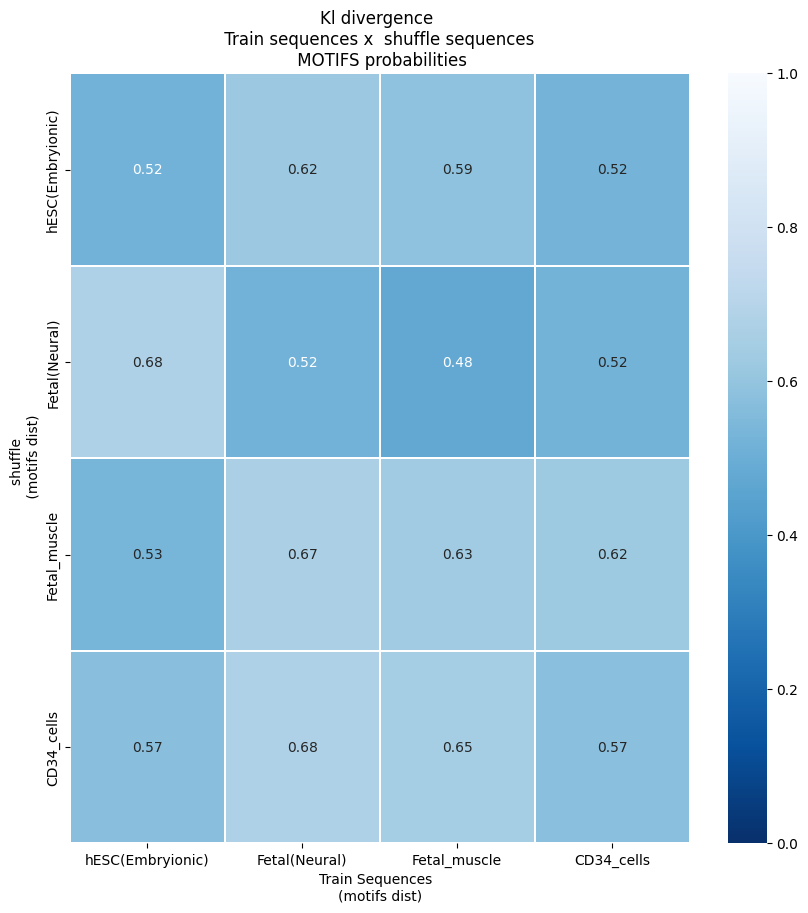

In [157]:
generate_heatmap_components(heat_train_shuffle, 'Train', 'shuffle')

In [158]:
dna_alphabet = ['A', 'C', 'T', 'G']
x_train_seq = np.array(
    [
        one_hot_encode(x, dna_alphabet, 200)
        for x in tqdm_notebook(df['raw_sequence'])
        if 'N' not in x
    ]
)
X_train = x_train_seq
X_train = np.array([x.T.tolist() for x in X_train])
X_train[X_train == 0] = -1
X_train.shape

/tmp/ipykernel_107684/853115864.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  x_train_seq = np.array([one_hot_encode(x, dna_alphabet, 200) for x in tqdm_notebook(df['raw_sequence']) if 'N' not in x ])


  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 4, 200)

## OVERFIT

In [159]:
# #Case want to test overfiiting (1500epochs)
# X_OVERFIT = np.array(X_train[0].tolist() * 200).reshape(-1,4,200)
# X_train = X_OVERFIT

# Train initialize and Training loop

In [160]:
# conditional training init
cell_types = sorted(list(df.component.unique()))
print(cell_types)
TOTAL_class_number = 17
x_train_cell_type = torch.from_numpy(df["component"].to_numpy())

[3, 8, 12, 15]


In [161]:
# x_train_cell_type = F.one_hot(torch.from_numpy(df["component"].to_numpy()), len(cell_types)+1)

In [162]:
tf = T.Compose([T.ToTensor()])
batch_size = 256
seq_dataset = SequenceDataset(seqs=X_train, c=x_train_cell_type, transform=tf)
train_dl = DataLoader(
    seq_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True
)

In [163]:
timesteps = 50

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps, beta_end=0.2)
# betas = cosine_beta_schedule(timesteps=timesteps,  s=0.0001 )
# define alphas
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
# sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = (
    betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
)


def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

0


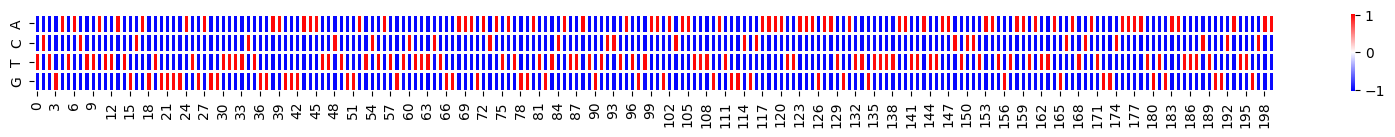

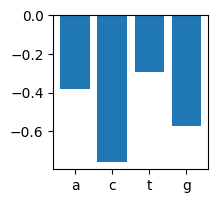

10


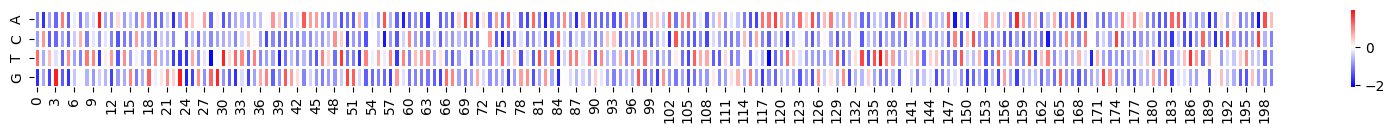

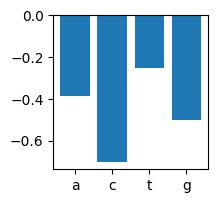

20


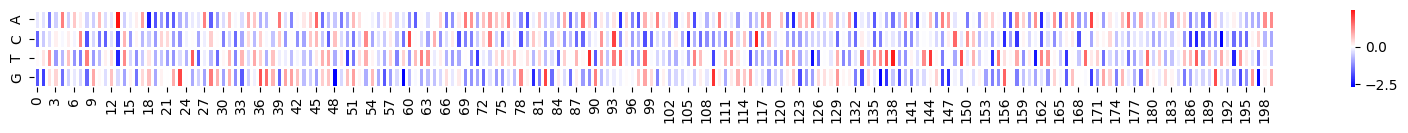

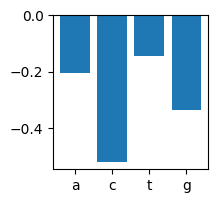

30


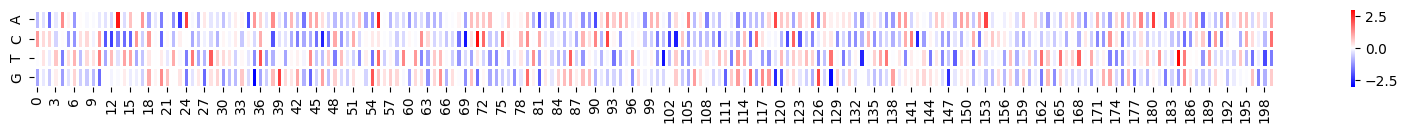

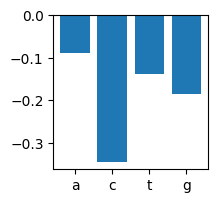

40


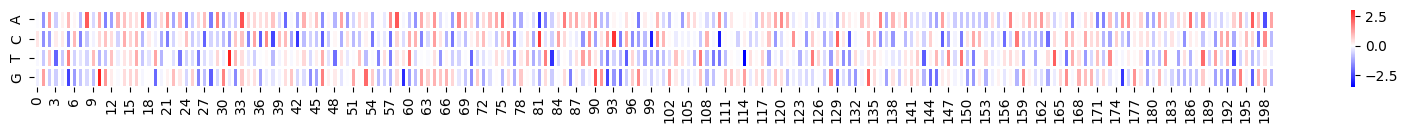

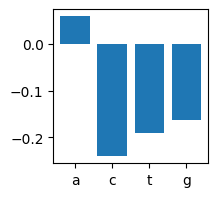

In [164]:
# Ploting images for a  foward pass example
for img_x_show, y in train_dl:
    for i in range(0, timesteps):
        if (i % 10) == 0:
            print(i)
            image_use = q_sample(img_x_show[0], t=torch.tensor([i]))
            image_use_numpy = image_use.numpy()

            plt.rcParams["figure.figsize"] = (20, 1)
            pd_seq = pd.DataFrame(image_use_numpy.reshape(4, 200))

            pd_seq.index = nucleotides
            sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0)
            plt.show()
            plt.rcParams["figure.figsize"] = (2, 2)

            plt.bar(['a', 'c', 't', 'g'], pd_seq.mean(1).T)
            plt.show()

    break

In [165]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [166]:
torch.cuda.empty_cache()

In [249]:
print(device)
image_size = 200
channels = 1

model = Unet_lucas(
    dim=200,
    channels=1,
    dim_mults=(1, 2, 4),
    resnet_block_groups=4,
    num_classes=TOTAL_class_number,
).cuda()

# model = Classifier() # 2d conv

model.to(device)

optimizer = Adam(model.parameters(), lr=1e-4)

from livelossplot import PlotLosses

train_kl, test_kl, shuffle_kl = 1, 1, 1
live_kl = PlotLosses(
    groups={'KL': ['train', 'test', 'shuffle'], 'DiffusionLoss': ['loss']}
)
# ,'Diffusion_Loss':['loss']
# live_kl.update({'train':train_kl, 'test':test_kl , 'shuffle':shuffle_kl , 'loss': 100})
train_kl, test_kl, shuffle_kl = 1, 1, 1

cuda
final 200 1 Conv2d(200, 1, kernel_size=(1, 1), stride=(1, 1))


In [251]:
#!pip install livelossplot

## Metrics: Train and Test should go down (train lower than test) and shuffle should go up

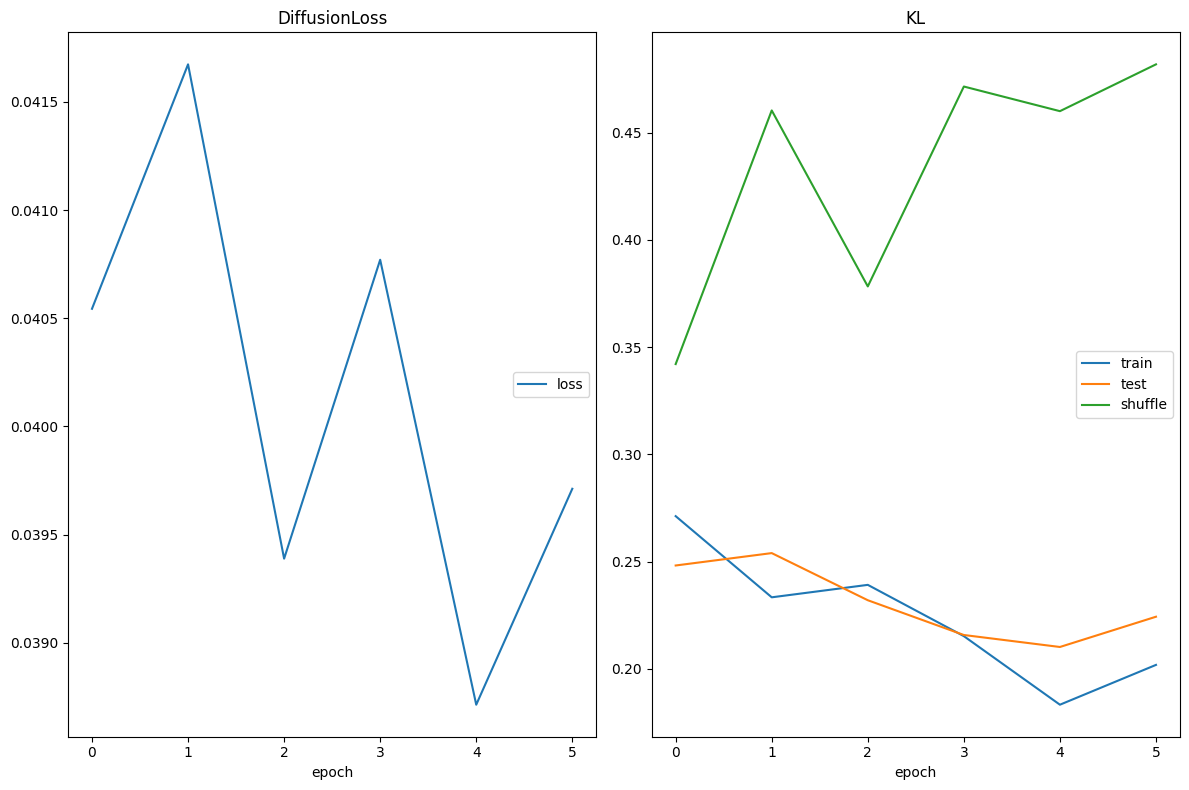

DiffusionLoss
	loss             	 (min:    0.039, max:    0.042, cur:    0.040)
KL
	train            	 (min:    0.183, max:    0.271, cur:    0.202)
	test             	 (min:    0.210, max:    0.254, cur:    0.224)
	shuffle          	 (min:    0.342, max:    0.482, cur:    0.482)
KL_TRAIN 0.20180512561977854 KL
KL_TEST 0.22427354058173316 KL
KL_SHUFFLE 0.4819055547986761 KL
 Epoch 1510 Loss: 0.0370929054915905
 Epoch 1520 Loss: 0.03857491910457611


KeyboardInterrupt: 

In [252]:
epochs = 10000
save_and_sample_every = 250
epochs_loss_show = 10

ema = EMA(0.995)
ema_model = copy.deepcopy(model).eval().requires_grad_(False)


for epoch in tqdm(range(epochs)):
    model.train()
    for step, batch in enumerate(train_dl):
        x, y = batch
        x = x.type(torch.float32).to(device)
        y = y.type(torch.long).to(device)

        # print (batch[0].dtype)
        batch_size = x.shape[0]
        # batch_size = batch["pixel_values"].shape[0]
        # batch = batch["pixel_values"].to(device)
        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(
            0, timesteps, (batch_size,), device=device
        ).long()  # sampling a t to generate t and t+1
        # print (t.dtype)
        # loss = p_losses(model, batch, t, loss_type="l2")
        # print (y)
        loss = p_losses(model, x, t, y, loss_type="huber")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ema.step_ema(ema_model, model)
        # live_kl.update({'train':train_kl, 'test':test_kl , 'shuffle':shuffle_kl , 'loss': loss.item()})
        # live_kl.send()

    if (epoch % epochs_loss_show) == 0:
        print(f" Epoch {epoch} Loss:", loss.item())

    # save generated images
    if epoch != 0 and epoch % save_and_sample_every == 0:
        model.eval()
        print('saving')
        milestone = step // save_and_sample_every
        sample_bs = 2
        # This needs to be fixed to the random
        sampled = torch.from_numpy(np.random.choice(cell_types, sample_bs))
        random_classes = sampled.cuda()

        samples = sample(
            model,
            classes=random_classes,
            image_size=image_size,
            batch_size=2,
            channels=1,
            cond_weight=1,
        )
        n_print = 0
        for image, class_show in zip(samples[-1], random_classes):
            if n_print < 4:
                plt.rcParams["figure.figsize"] = (20, 1)
                pd_seq = pd.DataFrame(image.reshape(4, 200))
                pd_seq.index = nucleotides
                sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0)
                plt.show()
                plt.rcParams["figure.figsize"] = (2, 2)

                plt.bar(['a', 'c', 't', 'g'], pd_seq.mean(1).T)
                plt.title(f'Class: {class_show}')
                plt.show()
                n_print = n_print + 1
        synt_df = sampling_to_metric(20)
        train_kl = compare_motif_list(synt_df, df_results_seq_guime_count_train)
        test_kl = compare_motif_list(synt_df, df_results_seq_guime_count_test)
        shuffle_kl = compare_motif_list(
            synt_df, df_results_seq_guime_count_shuffle
        )
        live_kl.update(
            {
                'train': train_kl,
                'test': test_kl,
                'shuffle': shuffle_kl,
                'loss': loss.item(),
            }
        )
        live_kl.send()
        print('KL_TRAIN', train_kl, 'KL')
        print('KL_TEST', test_kl, 'KL')
        print('KL_SHUFFLE', shuffle_kl, 'KL')

        # torch.save(model,'ALL_16_groups_conditioning_UNET_FULL_MODEL_EPOCHS_16k_CELLS.model')

In [ ]:
# torch.save(model,'UNET_FULL_MODEL_7000_EPOCHS_400_4_groups_CELLS.model')

In [ ]:
# ~6.5k

In [ ]:
# model = torch.load('ALL_16_groups_conditioning_UNET_FULL_MODEL_EPOCHS_16k_CELLS.model')
# model.to(device)

## Module metric by component

In [253]:
def kl_comparison_generated_sequences(components_list, dict_targer_components):
    '''
    ex: components_list = [3, 8, 12, 15]
    '''
    final_comp_kl = []
    use_comp_list = components_list
    for r in use_comp_list:
        print(r), 'component'
        comp_array = []
        group_compare = r
        synt_df_cond = sampling_to_metric(
            20, True, group_compare, cond_weight_to_metric=1
        )
        for k in use_comp_list:
            v = dict_targer_components[k]

            kl_out = compare_motif_list(synt_df_cond, v)
            print(r, k, kl_out)
            comp_array.append(kl_out)
        final_comp_kl.append(comp_array)
    return final_comp_kl

3


/tmp/ipykernel_107684/504900927.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(number_of_samples)): # generating 20*10 sequences


  0%|          | 0/20 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

scanning: 100%|███████████████████████| 200/200 [00:06<00:00, 33.15 sequences/s]


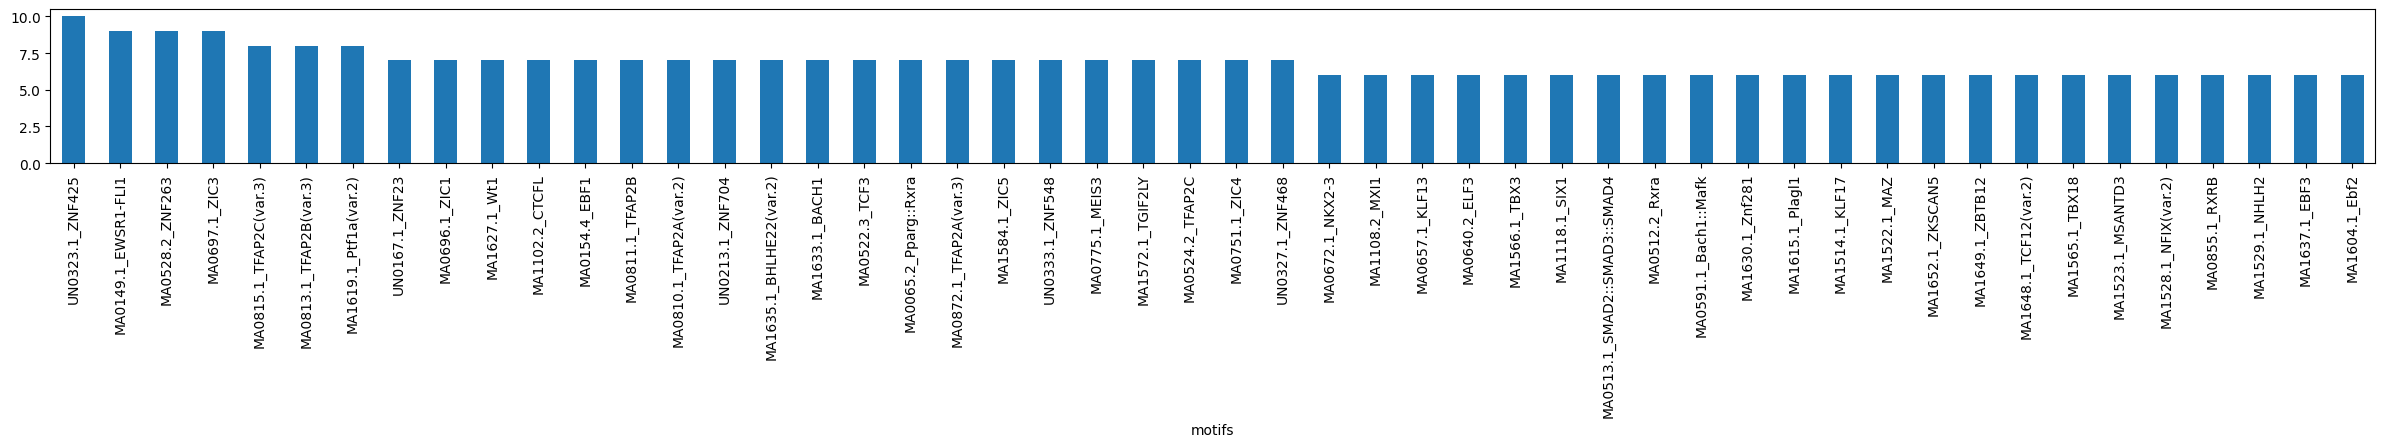

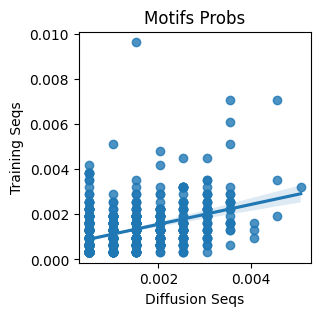

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        2        0.001523       0.000642
1    UN0249.1_ZSCAN9        3        4        0.001523       0.001285
2       MA0663.1_MLX        3        2        0.001523       0.000642
3     MA0160.1_NR4A2        3        5        0.001523       0.001606
4     MA0910.2_HOXD8        1        4        0.000508       0.001285
..               ...      ...      ...             ...            ...
821    MA1491.1_GLI3        3        8        0.001523       0.002570
822   MA0775.1_MEIS3        7        5        0.003553       0.001606
823   MA1505.1_HOXC8        1        6        0.000508       0.001927
824   MA1111.1_NR2F2        2        2        0.001015       0.000642
825    MA0641.1_ELF4        2        4        0.001015       0.001285

[826 rows x 5 columns]

3 3 0.2587272474582676


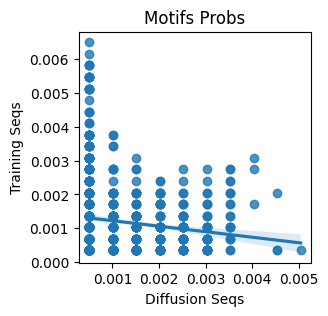

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        3        0.001513       0.001026
1    UN0249.1_ZSCAN9        3        2        0.001513       0.000684
2       MA0663.1_MLX        3        2        0.001513       0.000684
3     MA0160.1_NR4A2        3        3        0.001513       0.001026
4     MA0910.2_HOXD8        1        5        0.000504       0.001711
..               ...      ...      ...             ...            ...
834    MA1491.1_GLI3        3        2        0.001513       0.000684
835   MA0775.1_MEIS3        7        7        0.003530       0.002395
836   MA1505.1_HOXC8        1        8        0.000504       0.002737
837   MA1111.1_NR2F2        2        1        0.001009       0.000342
838    MA0641.1_ELF4        2        1        0.001009       0.000342

[839 rows x 5 columns]

3 8 0.5905450731637075


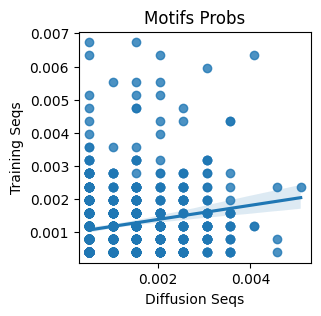

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        3        0.001527       0.001188
1    UN0249.1_ZSCAN9        3        2        0.001527       0.000792
2       MA0663.1_MLX        3        6        0.001527       0.002376
3     MA0160.1_NR4A2        3        4        0.001527       0.001584
4     MA0910.2_HOXD8        1        2        0.000509       0.000792
..               ...      ...      ...             ...            ...
815    MA1491.1_GLI3        3        8        0.001527       0.003168
816   MA0775.1_MEIS3        7       11        0.003564       0.004356
817   MA1505.1_HOXC8        1        1        0.000509       0.000396
818   MA1111.1_NR2F2        2        1        0.001018       0.000396
819    MA0641.1_ELF4        2        5        0.001018       0.001980

[820 rows x 5 columns]

3 12 0.38674102486397266


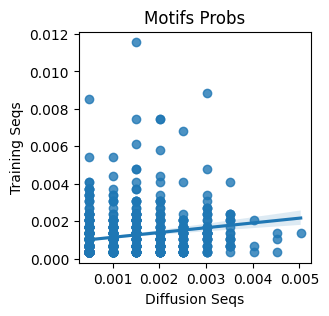

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        3        6        0.001508        0.00204
1    UN0249.1_ZSCAN9        3        2        0.001508        0.00068
2       MA0663.1_MLX        3        3        0.001508        0.00102
3     MA0160.1_NR4A2        3        4        0.001508        0.00136
4     MA0910.2_HOXD8        1        4        0.000503        0.00136
..               ...      ...      ...             ...            ...
840    MA1491.1_GLI3        3        3        0.001508        0.00102
841   MA0775.1_MEIS3        7        6        0.003519        0.00204
842   MA1505.1_HOXC8        1        1        0.000503        0.00034
843   MA1111.1_NR2F2        2        2        0.001006        0.00068
844    MA0641.1_ELF4        2       10        0.001006        0.00340

[845 rows x 5 columns]

3 15 0.39968419683160034
8


/tmp/ipykernel_107684/504900927.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(number_of_samples)): # generating 20*10 sequences


  0%|          | 0/20 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

scanning: 100%|███████████████████████| 200/200 [00:06<00:00, 33.04 sequences/s]


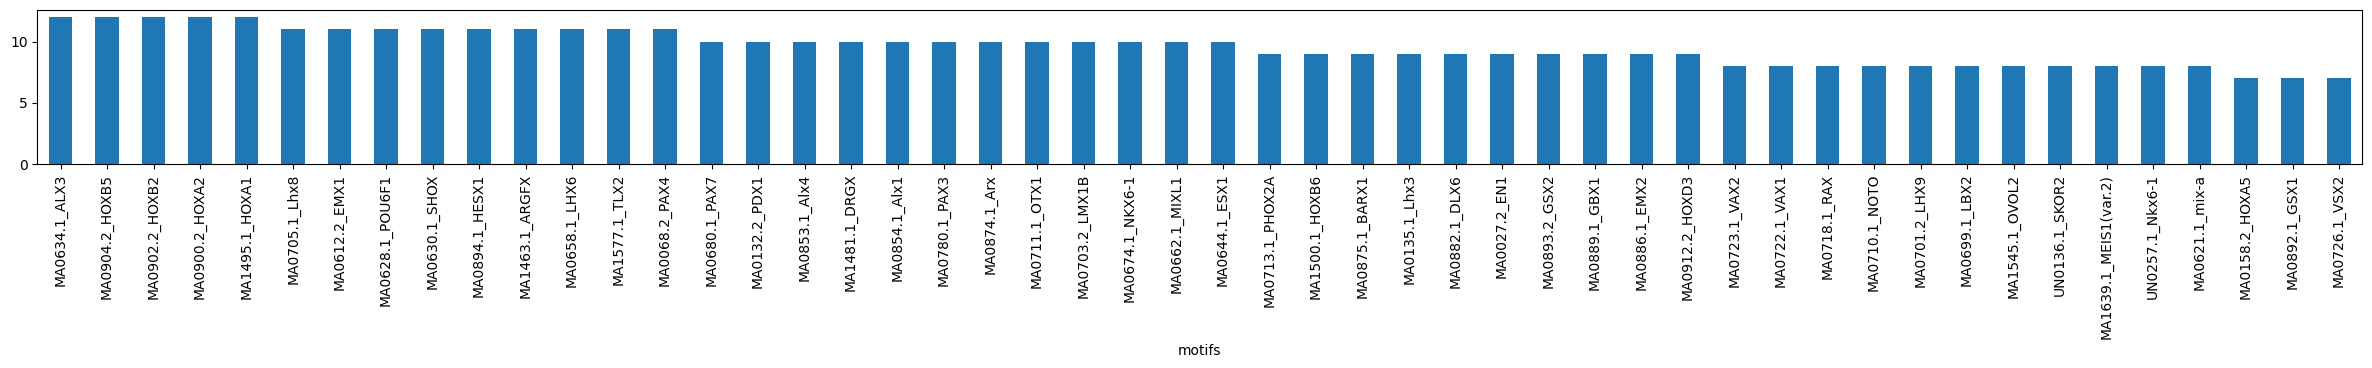

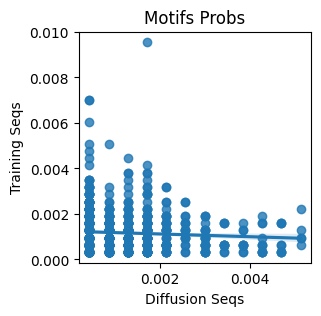

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        4        2        0.001711       0.000637
1    UN0249.1_ZSCAN9        7        4        0.002994       0.001273
2       MA0663.1_MLX        2        2        0.000855       0.000637
3     MA0160.1_NR4A2        1        5        0.000428       0.001591
4     MA0910.2_HOXD8        3        4        0.001283       0.001273
..               ...      ...      ...             ...            ...
850    MA1491.1_GLI3        1        8        0.000428       0.002546
851   MA0775.1_MEIS3        2        5        0.000855       0.001591
852   MA1505.1_HOXC8        7        6        0.002994       0.001910
853   MA1111.1_NR2F2        1        2        0.000428       0.000637
854    MA0868.2_SOX8        2        7        0.000855       0.002228

[855 rows x 5 columns]

8 3 0.5797223825154924


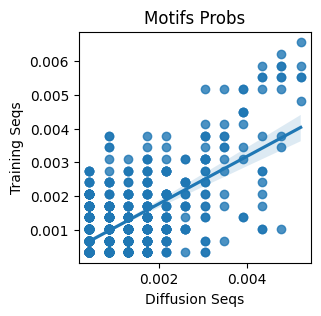

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        4        3        0.001739       0.001034
1    UN0249.1_ZSCAN9        7        2        0.003043       0.000689
2       MA0663.1_MLX        2        2        0.000870       0.000689
3     MA0160.1_NR4A2        1        3        0.000435       0.001034
4     MA0910.2_HOXD8        3        5        0.001304       0.001724
..               ...      ...      ...             ...            ...
812    MA1484.1_ETS2        1        1        0.000435       0.000345
813    MA1491.1_GLI3        1        2        0.000435       0.000689
814   MA0775.1_MEIS3        2        7        0.000870       0.002413
815   MA1505.1_HOXC8        7        8        0.003043       0.002758
816    MA0868.2_SOX8        2        6        0.000870       0.002068

[817 rows x 5 columns]

8 8 0.24362342104047124


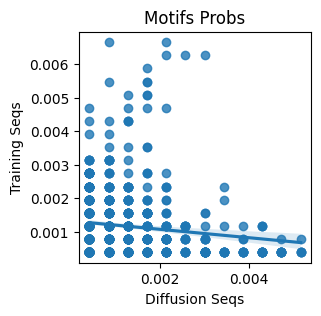

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        4        3        0.001716       0.001175
1    UN0249.1_ZSCAN9        7        2        0.003003       0.000783
2       MA0663.1_MLX        2        6        0.000858       0.002350
3     MA0160.1_NR4A2        1        4        0.000429       0.001567
4     MA0910.2_HOXD8        3        2        0.001287       0.000783
..               ...      ...      ...             ...            ...
843  UN0238.1_ZNF823        1        2        0.000429       0.000783
844    MA1491.1_GLI3        1        8        0.000429       0.003134
845   MA0775.1_MEIS3        2       11        0.000858       0.004309
846   MA1505.1_HOXC8        7        1        0.003003       0.000392
847    MA0868.2_SOX8        2        1        0.000858       0.000392

[848 rows x 5 columns]

8 12 0.6889257232002073


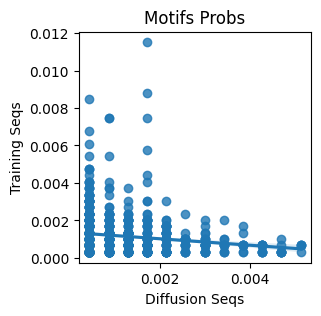

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        4        6        0.001709       0.002031
1    UN0249.1_ZSCAN9        7        2        0.002990       0.000677
2       MA0663.1_MLX        2        3        0.000854       0.001016
3     MA0160.1_NR4A2        1        4        0.000427       0.001354
4     MA0910.2_HOXD8        3        4        0.001282       0.001354
..               ...      ...      ...             ...            ...
853    MA1491.1_GLI3        1        3        0.000427       0.001016
854   MA0775.1_MEIS3        2        6        0.000854       0.002031
855   MA1505.1_HOXC8        7        1        0.002990       0.000339
856   MA1111.1_NR2F2        1        2        0.000427       0.000677
857    MA0868.2_SOX8        2        2        0.000854       0.000677

[858 rows x 5 columns]

8 15 0.7038859076278158
12


/tmp/ipykernel_107684/504900927.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(number_of_samples)): # generating 20*10 sequences


  0%|          | 0/20 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

scanning: 100%|███████████████████████| 200/200 [00:05<00:00, 34.46 sequences/s]


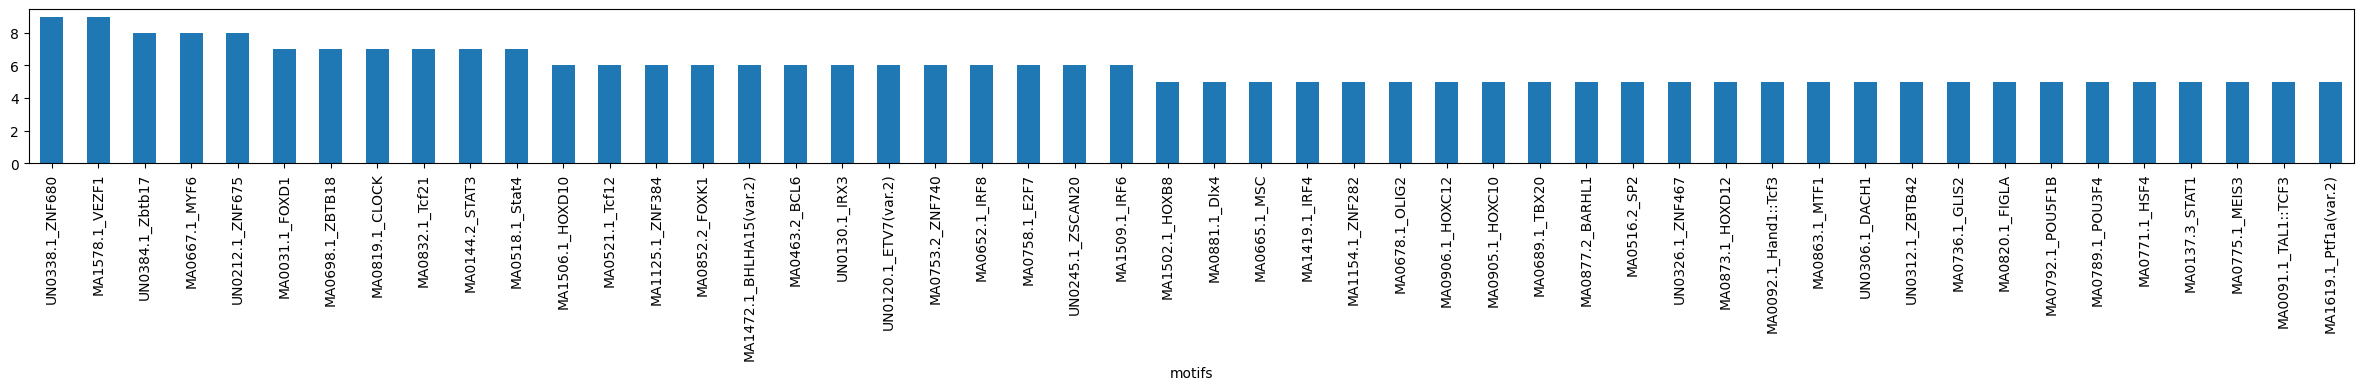

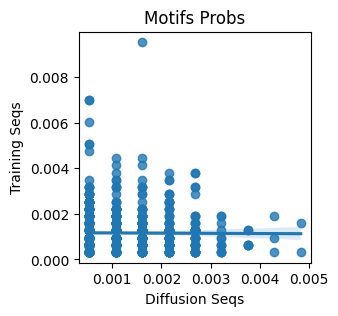

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        1        2        0.000536       0.000636
1    UN0249.1_ZSCAN9        2        4        0.001072       0.001271
2       MA0663.1_MLX        2        2        0.001072       0.000636
3     MA0160.1_NR4A2        1        5        0.000536       0.001589
4     MA0910.2_HOXD8        3        4        0.001609       0.001271
..               ...      ...      ...             ...            ...
855    MA1491.1_GLI3        3        8        0.001609       0.002542
856   MA0775.1_MEIS3        5        5        0.002681       0.001589
857   MA1505.1_HOXC8        1        6        0.000536       0.001907
858   MA1111.1_NR2F2        1        2        0.000536       0.000636
859    MA0641.1_ELF4        3        4        0.001609       0.001271

[860 rows x 5 columns]

12 3 0.45868413394113516


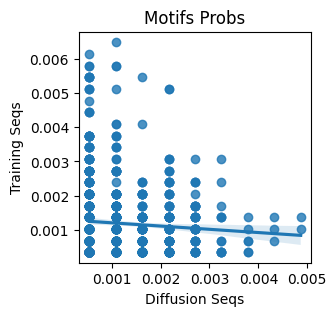

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        1        3        0.000541       0.001025
1    UN0249.1_ZSCAN9        2        2        0.001082       0.000683
2       MA0663.1_MLX        2        2        0.001082       0.000683
3     MA0160.1_NR4A2        1        3        0.000541       0.001025
4     MA0910.2_HOXD8        3        5        0.001622       0.001708
..               ...      ...      ...             ...            ...
839   MA0840.1_Creb5        1        2        0.000541       0.000683
840    MA1491.1_GLI3        3        2        0.001622       0.000683
841   MA0775.1_MEIS3        5        7        0.002704       0.002391
842   MA1505.1_HOXC8        1        8        0.000541       0.002732
843    MA0641.1_ELF4        3        1        0.001622       0.000342

[844 rows x 5 columns]

12 8 0.5179643083909667


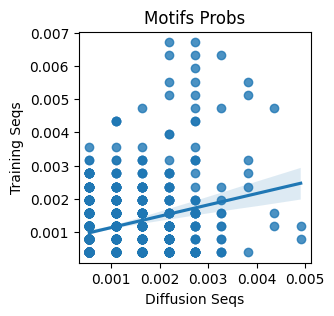

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        1        3        0.000546       0.001184
1    UN0249.1_ZSCAN9        2        2        0.001091       0.000790
2       MA0663.1_MLX        2        6        0.001091       0.002369
3     MA0160.1_NR4A2        1        4        0.000546       0.001579
4     MA0910.2_HOXD8        3        2        0.001637       0.000790
..               ...      ...      ...             ...            ...
823   MA0840.1_Creb5        1        2        0.000546       0.000790
824    MA1491.1_GLI3        3        8        0.001637       0.003158
825   MA0775.1_MEIS3        5       11        0.002728       0.004343
826   MA1505.1_HOXC8        1        1        0.000546       0.000395
827    MA0641.1_ELF4        3        5        0.001637       0.001974

[828 rows x 5 columns]

12 12 0.36055293837479985


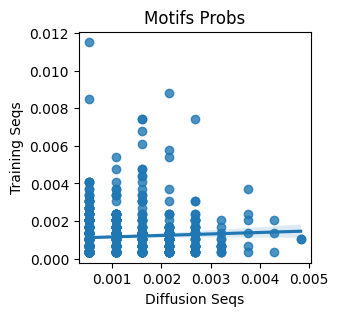

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        1        6        0.000537       0.002031
1    UN0249.1_ZSCAN9        2        2        0.001074       0.000677
2       MA0663.1_MLX        2        3        0.001074       0.001016
3     MA0160.1_NR4A2        1        4        0.000537       0.001354
4     MA0910.2_HOXD8        3        4        0.001610       0.001354
..               ...      ...      ...             ...            ...
853    MA1491.1_GLI3        3        3        0.001610       0.001016
854   MA0775.1_MEIS3        5        6        0.002684       0.002031
855   MA1505.1_HOXC8        1        1        0.000537       0.000339
856   MA1111.1_NR2F2        1        2        0.000537       0.000677
857    MA0641.1_ELF4        3       10        0.001610       0.003385

[858 rows x 5 columns]

12 15 0.4683390457614769
15


/tmp/ipykernel_107684/504900927.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(number_of_samples)): # generating 20*10 sequences


  0%|          | 0/20 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

specific


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

scanning: 100%|███████████████████████| 200/200 [00:05<00:00, 35.00 sequences/s]


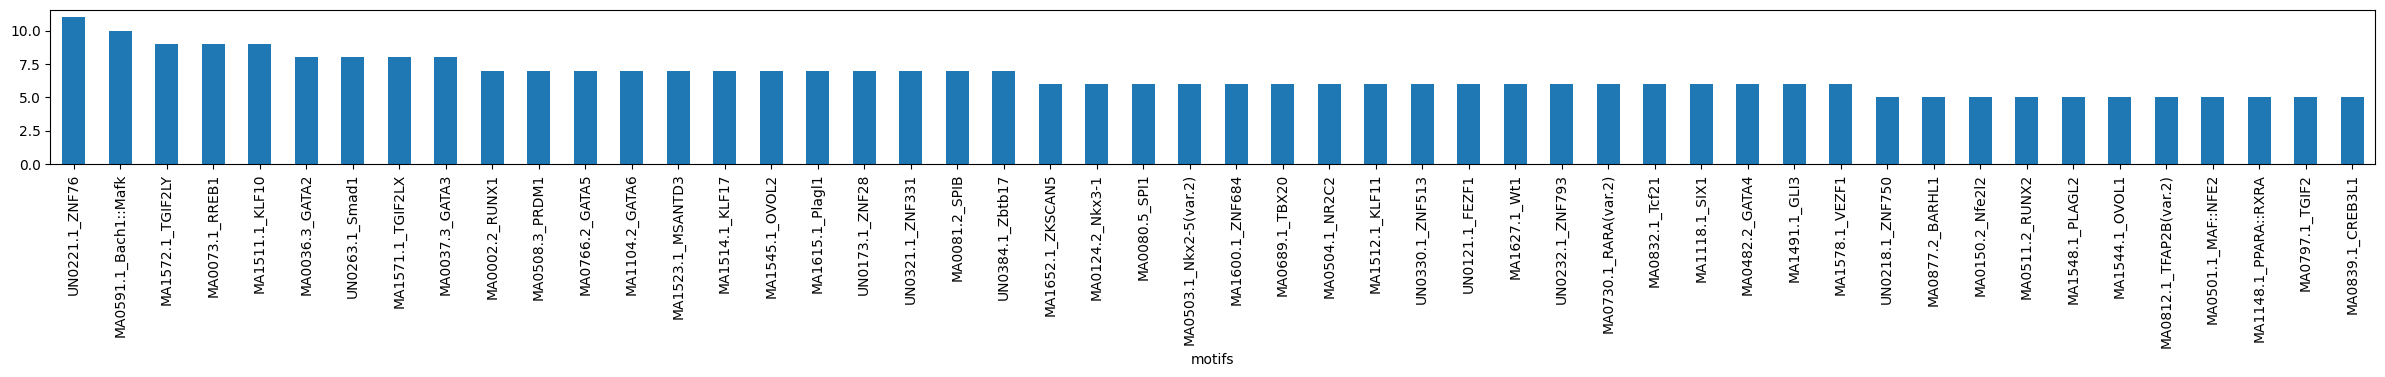

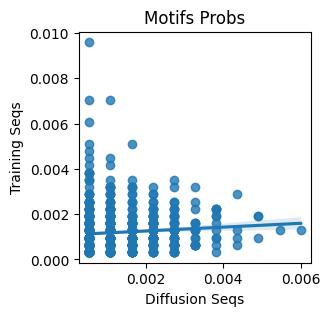

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        5        2        0.002726       0.000639
1    UN0249.1_ZSCAN9        3        4        0.001636       0.001278
2       MA0663.1_MLX        1        2        0.000545       0.000639
3     MA0160.1_NR4A2        3        5        0.001636       0.001598
4     MA0910.2_HOXD8        2        4        0.001091       0.001278
..               ...      ...      ...             ...            ...
837    MA1491.1_GLI3        6        8        0.003272       0.002557
838   MA0775.1_MEIS3        2        5        0.001091       0.001598
839   MA1505.1_HOXC8        1        6        0.000545       0.001918
840   MA1111.1_NR2F2        2        2        0.001091       0.000639
841    MA0641.1_ELF4        1        4        0.000545       0.001278

[842 rows x 5 columns]

15 3 0.3965077111151144


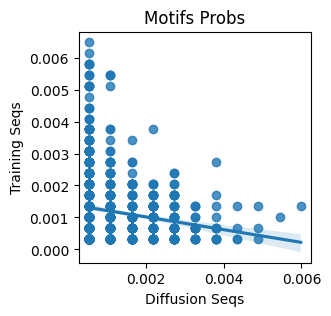

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        5        3        0.002719       0.001024
1    UN0249.1_ZSCAN9        3        2        0.001631       0.000682
2       MA0663.1_MLX        1        2        0.000544       0.000682
3     MA0160.1_NR4A2        3        3        0.001631       0.001024
4     MA0910.2_HOXD8        2        5        0.001088       0.001706
..               ...      ...      ...             ...            ...
842    MA1491.1_GLI3        6        2        0.003263       0.000682
843   MA0775.1_MEIS3        2        7        0.001088       0.002388
844   MA1505.1_HOXC8        1        8        0.000544       0.002729
845   MA1111.1_NR2F2        2        1        0.001088       0.000341
846    MA0641.1_ELF4        1        1        0.000544       0.000341

[847 rows x 5 columns]

15 8 0.6112553981315413


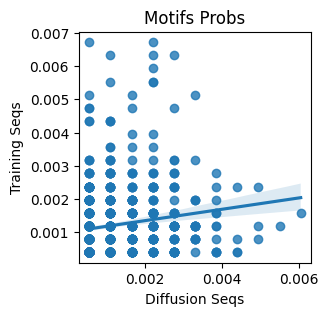

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        5        3        0.002752       0.001186
1    UN0249.1_ZSCAN9        3        2        0.001651       0.000791
2       MA0663.1_MLX        1        6        0.000550       0.002372
3     MA0160.1_NR4A2        3        4        0.001651       0.001581
4     MA0910.2_HOXD8        2        2        0.001101       0.000791
..               ...      ...      ...             ...            ...
820    MA1491.1_GLI3        6        8        0.003302       0.003162
821   MA0775.1_MEIS3        2       11        0.001101       0.004348
822   MA1505.1_HOXC8        1        1        0.000550       0.000395
823   MA1111.1_NR2F2        2        1        0.001101       0.000395
824    MA0641.1_ELF4        1        5        0.000550       0.001976

[825 rows x 5 columns]

15 12 0.40093492696615185


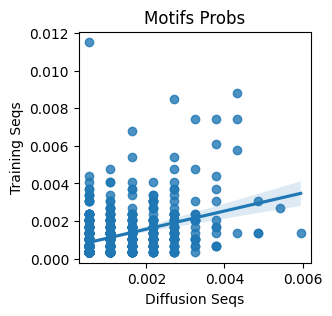

motif  motif_a  motif_b  Diffusion_seqs  Training_seqs
0    MA1656.1_ZNF449        5        6        0.002706       0.002033
1    UN0249.1_ZSCAN9        3        2        0.001623       0.000678
2       MA0663.1_MLX        1        3        0.000541       0.001016
3     MA0160.1_NR4A2        3        4        0.001623       0.001355
4     MA0910.2_HOXD8        2        4        0.001082       0.001355
..               ...      ...      ...             ...            ...
851    MA1491.1_GLI3        6        3        0.003247       0.001016
852   MA0775.1_MEIS3        2        6        0.001082       0.002033
853   MA1505.1_HOXC8        1        1        0.000541       0.000339
854   MA1111.1_NR2F2        2        2        0.001082       0.000678
855    MA0641.1_ELF4        1       10        0.000541       0.003388

[856 rows x 5 columns]

15 15 0.3206164521181549


In [257]:
use_comp = [3, 8, 12, 15]
heat_new_sequences_test = kl_comparison_generated_sequences(
    use_comp, final_comp_values_trian
)

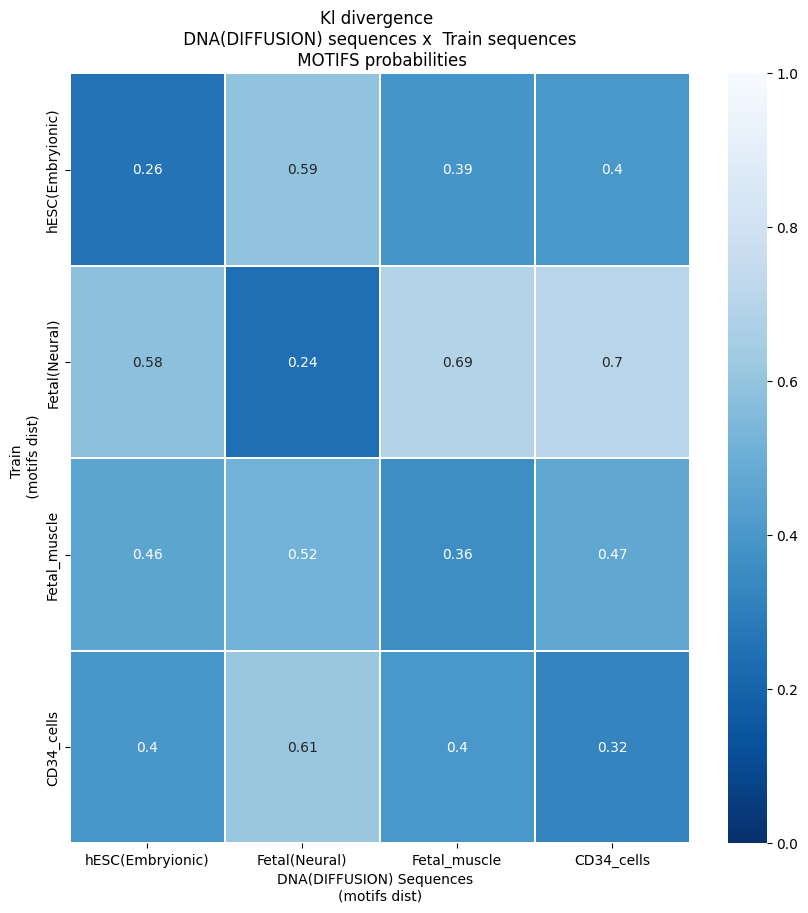

In [258]:
generate_heatmap_components(heat_new_sequences_test, 'DNA(DIFFUSION)', 'Train')

# The Lowest values should be present from the up to bottown diagonal ~ 1000 epochs 